In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
singapore_df = pd.read_csv('datasets/singapore_listings.csv')
ny_df = pd.read_csv('datasets/newyorkcity_listings.csv')
madrid_df = pd.read_csv('datasets/madrid_listings.csv')

In [23]:
def print_outliers(df,features=None):
   
    # Define the numeric features
    if features is None:
        features = [
            'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price'
        ]

    if len(features)==1:
        sns.boxplot(x=df[features[0]])
        plt.title(f'Boxplot for {features[0]}')
        plt.xlabel(features[0])
        plt.show()
    else:
        # Create boxplots to visually identify outliers in each numeric feature
        boxplot_figure, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 8))
        for i, feature in enumerate(features):
            sns.boxplot(x=df[feature], ax=axes[i])
            axes[i].set_title(f'Boxplot for {feature}')
            axes[i].set_xlabel(feature)

        # Display the boxplots
        boxplot_figure.tight_layout()
        boxplot_figure.show()

def print_graphs(df):
    # Creating a large figure to hold all subplots
    fig, axes = plt.subplots(3, 3, figsize=(25, 20))

    # Histograms
    sns.histplot(df, x='price', kde=True, ax=axes[0,0])
    axes[0,0].set_title('Price Frequency')

    sns.histplot(df, x='minimum_nights', kde=True, ax=axes[0,1])
    axes[0,1].set_title('Minimum Nights Frequency')

    sns.histplot(df, x='number_of_reviews', kde=True, ax=axes[0,2])
    axes[0,2].set_title('Review Frequency')

    sns.histplot(df, x='availability_365', kde=True, ax=axes[1,0])
    axes[1,0].set_title('Availability Frequency')

    sns.histplot(df, x='calculated_host_listings_count', kde=True, ax=axes[1,1])
    axes[1,1].set_title('Host Listings Frequency')

    sns.histplot(df, x='reviews_per_month', kde=True, ax=axes[1,2])
    axes[1,2].set_title('Monthly Review Frequency')

    # Count plots
    sns.countplot(data=df, y='neighbourhood_group', ax=axes[2,0])
    axes[2,0].set_title('Frequency of Neighbourhood Groups')

    sns.countplot(data=df, x='room_type', ax=axes[2,1])
    axes[2,1].set_title('Frequency of Various Rooms')

    # Catplot doesn't fit into axes easily; using factorplot instead for integrated axes
    sns.countplot(data=df, hue='room_type', y='neighbourhood_group', ax=axes[2,2])
    axes[2,2].set_title('Room Type Distribution per Neighbourhood Group')

    # Adjust layout for better fit and to prevent overlap
    plt.tight_layout()
    plt.show()

### Exploratory Data Analysis (EDA)

#### Singapore

In [3]:
singapore_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [49]:
singapore_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.907000e+03,7.907000e+03,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,5149.000000,7907.000000,7907.000000
mean,2.338862e+07,9.114481e+07,1.314192,103.848787,169.332996,17.510054,12.807386,1.043669,40.607689,208.726318
std,1.016416e+07,8.190910e+07,0.030577,0.043675,340.187599,42.094616,29.707746,1.285851,65.135253,146.120034
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.582180e+07,2.305808e+07,1.295795,103.835825,65.000000,1.000000,0.000000,0.180000,2.000000,54.000000
50%,2.470627e+07,6.344891e+07,1.311030,103.849410,124.000000,3.000000,2.000000,0.550000,9.000000,260.000000
75%,3.234850e+07,1.553811e+08,1.322110,103.872535,199.000000,10.000000,10.000000,1.370000,48.000000,355.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,10000.000000,1000.000000,323.000000,13.000000,274.000000,365.000000


In [12]:
missing_data = singapore_df.isnull().sum()
missing_data[missing_data > 0]

name                    2
last_review          2758
reviews_per_month    2758
dtype: int64

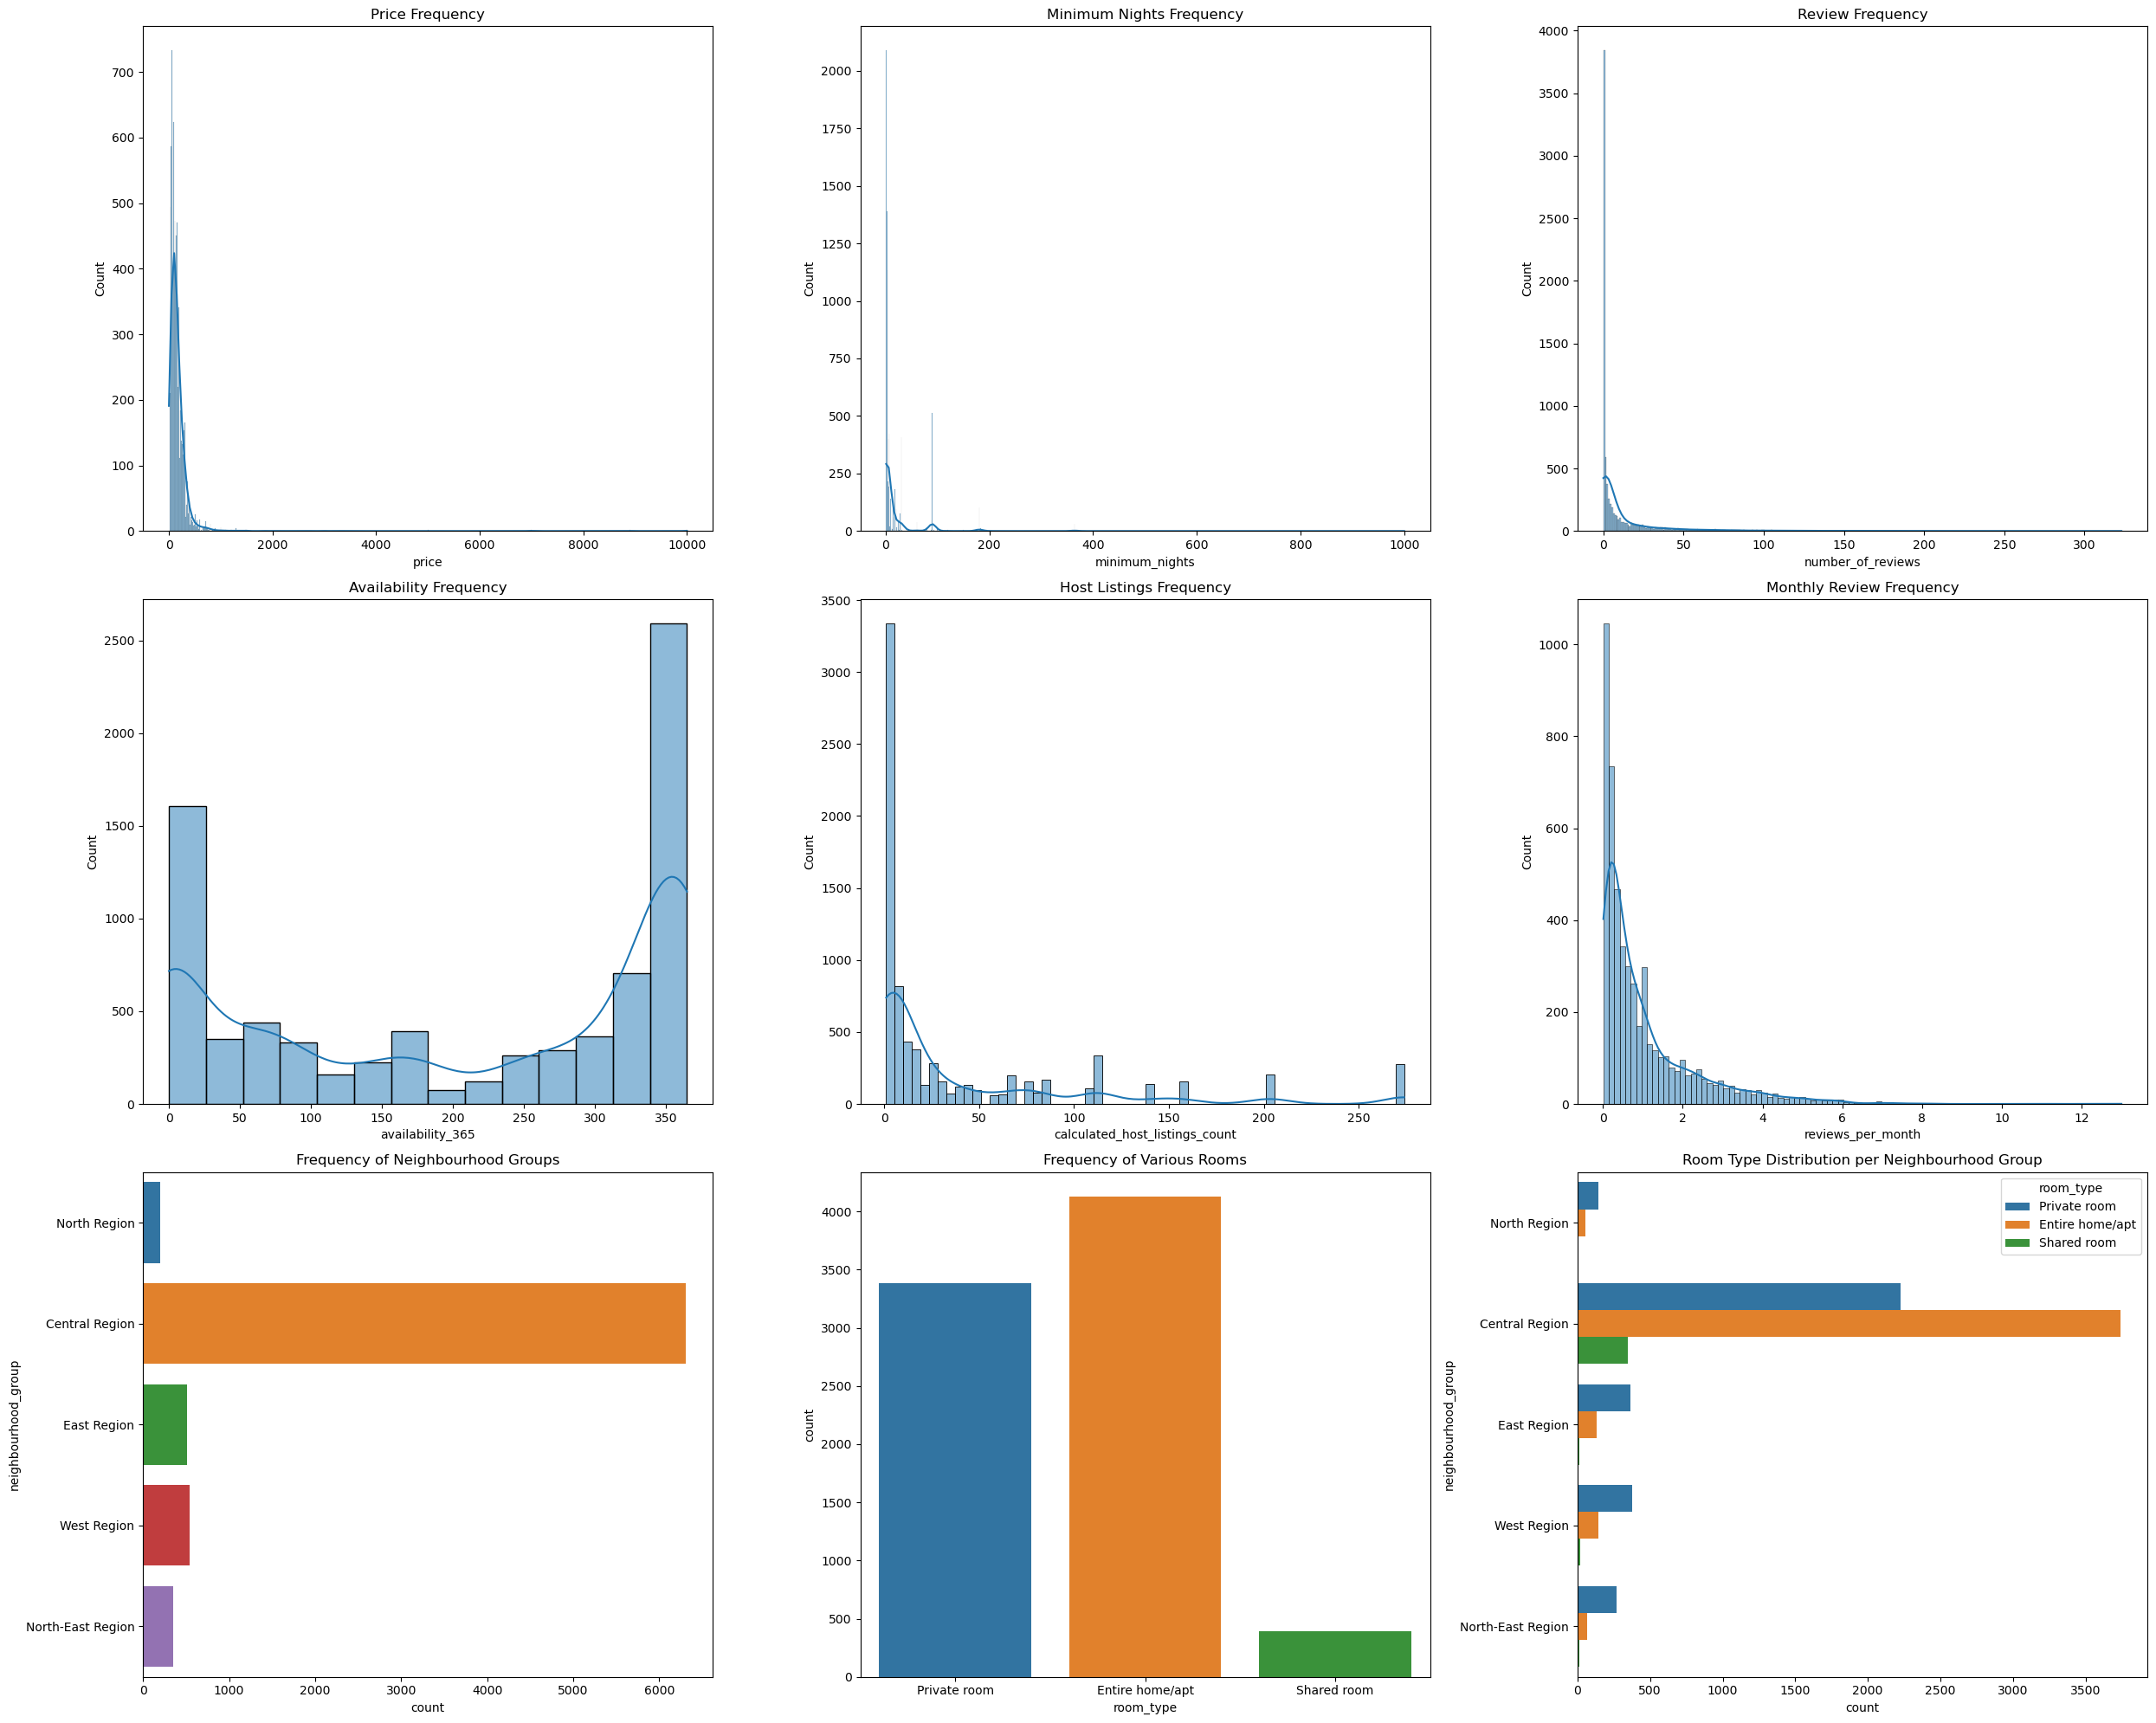

In [24]:
print_graphs(singapore_df)

#### New York

In [6]:
ny_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [48]:
ny_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [17]:
missing_data = ny_df.isnull().sum()
missing_data[missing_data > 0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

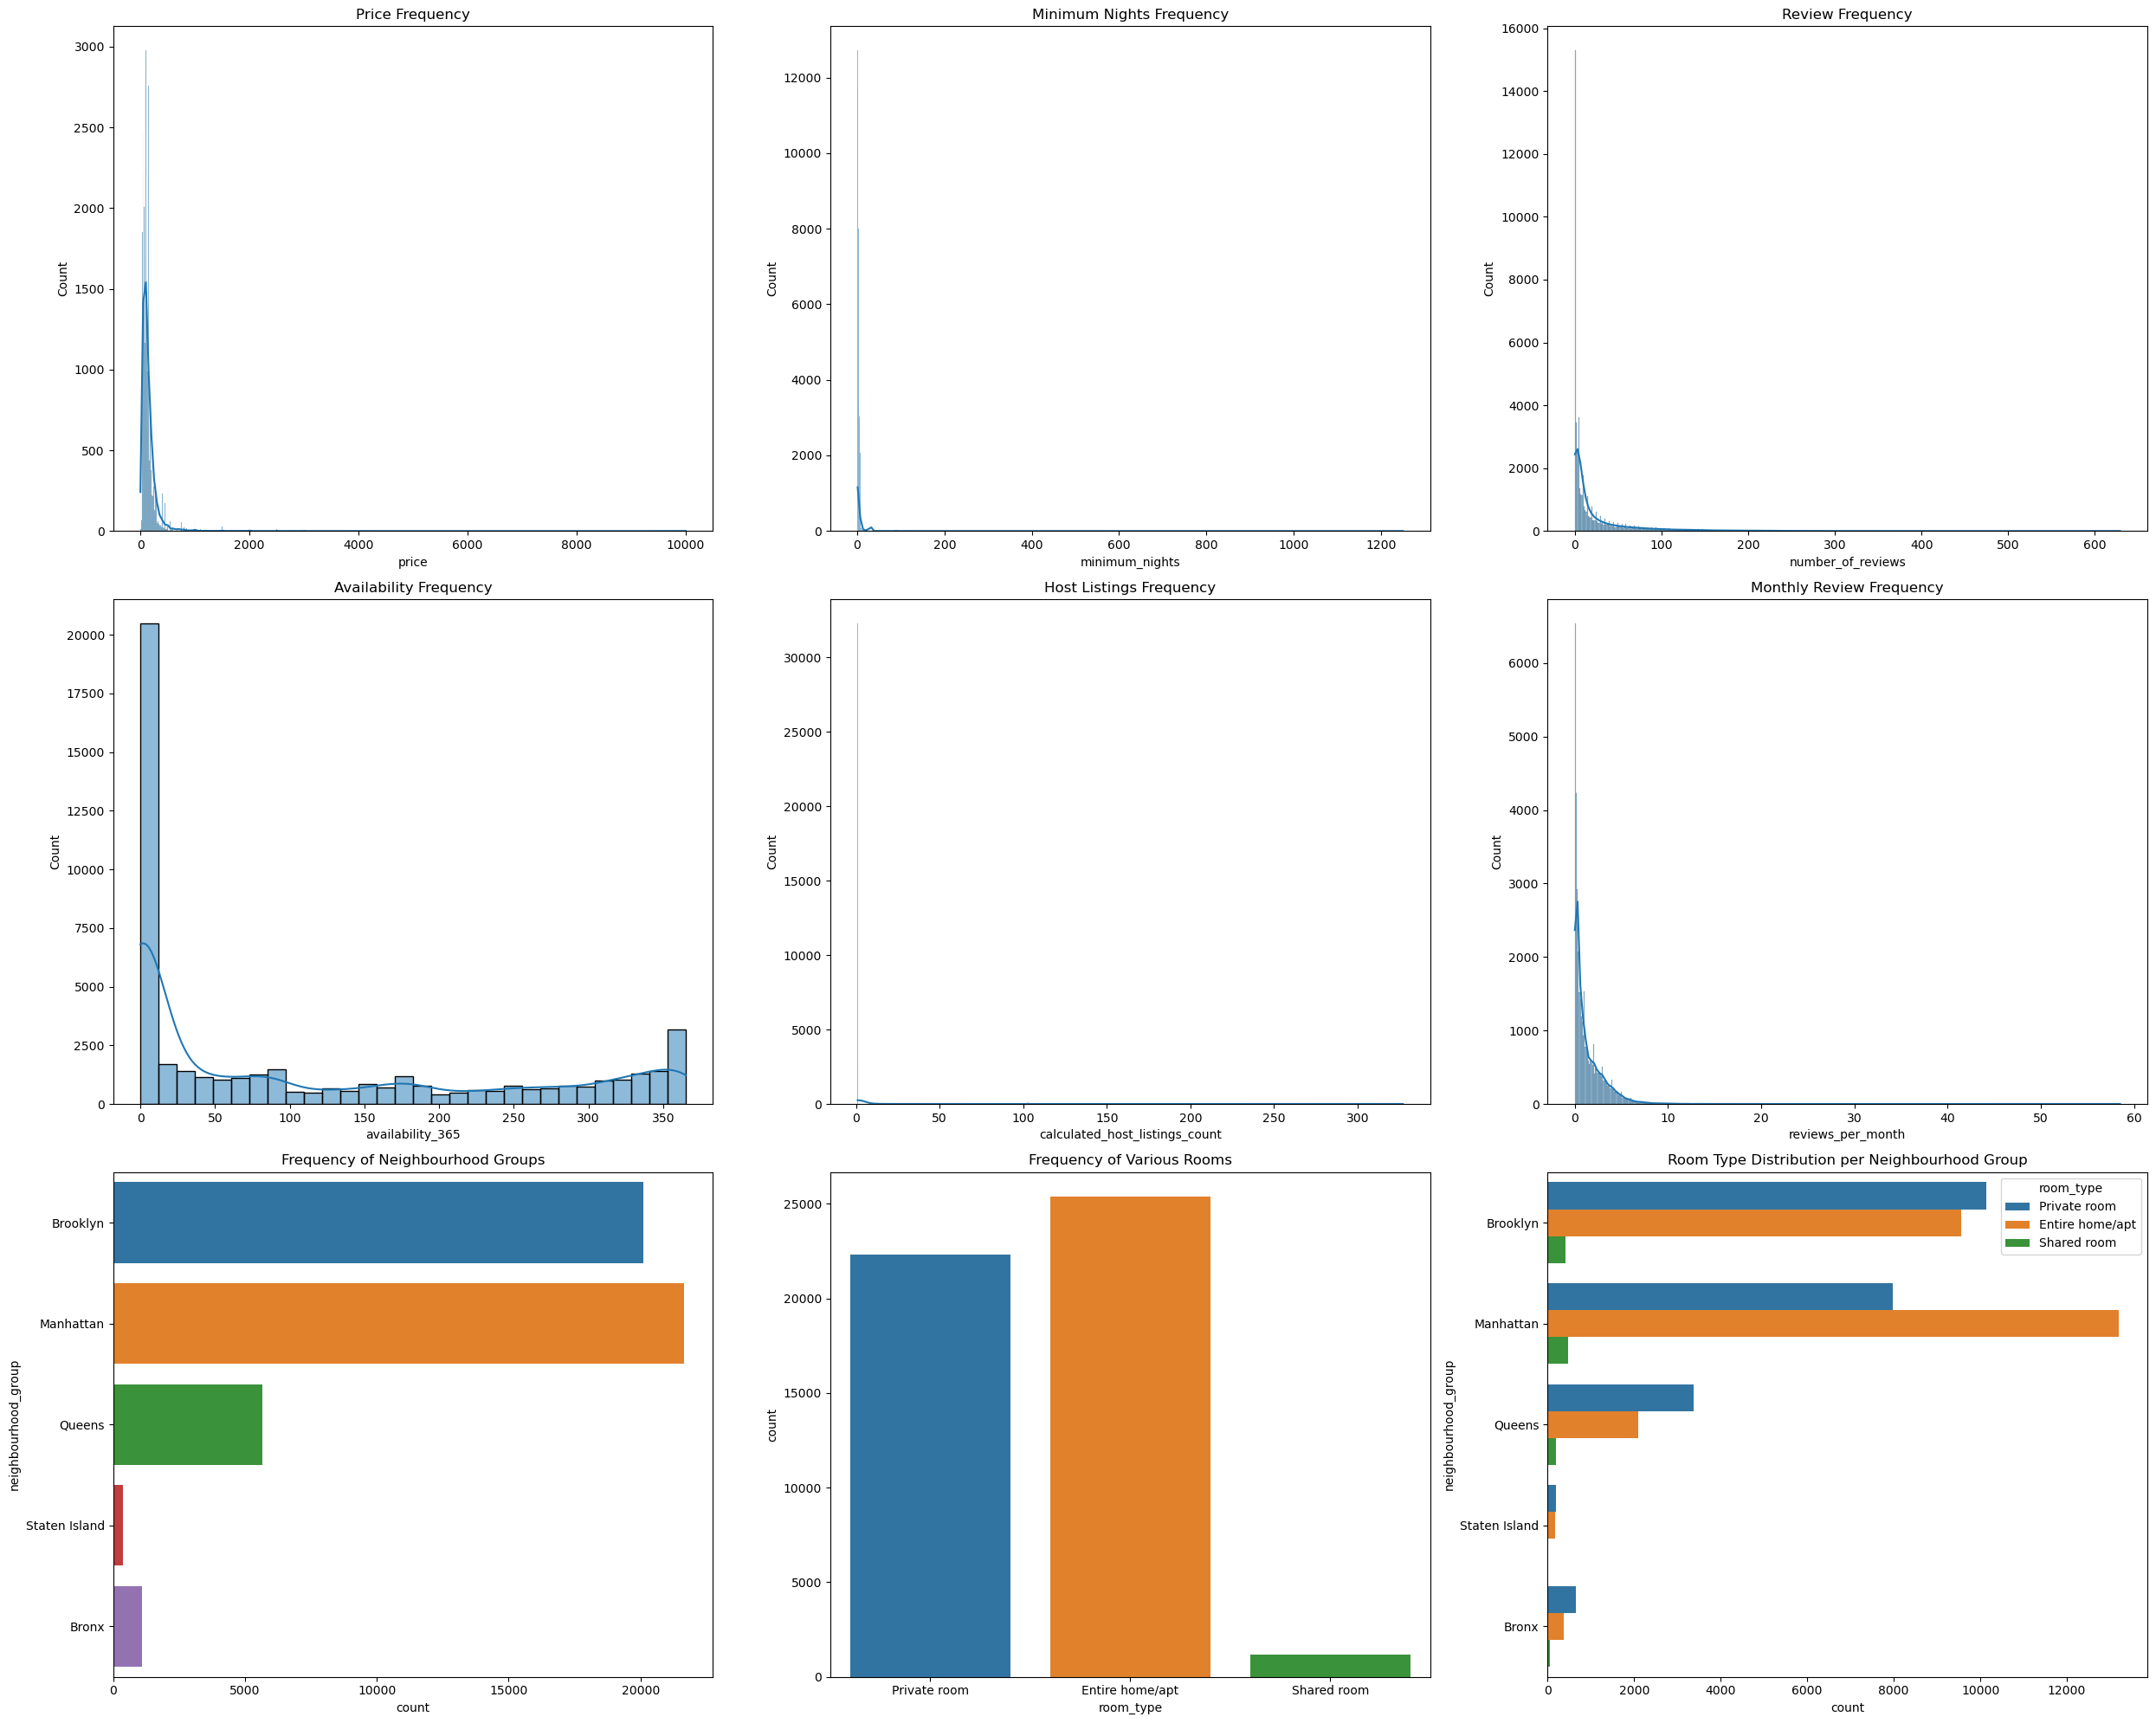

In [25]:
print_graphs(ny_df)

#### Madrid

In [19]:
# Madrid
madrid_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,78,2020-09-20,0.58,1,180
1,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,33,2018-07-15,0.42,2,364
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Jesus,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,0,NaN,NaN,7,1
3,24805,Gran Via Studio Madrid,346366726,A,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,10,2020-03-01,0.13,1,72
4,26825,Single Room whith private Bathroom,114340,Agustina,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,149,2020-03-12,1.12,1,365


In [20]:
madrid_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1.961800e+04,1.961800e+04,19618.000000,19618.000000,19618.000000,19618.000000,19618.000000,13981.000000,19618.000000,19618.000000
mean,2.912200e+07,1.312165e+08,40.420984,-3.694040,129.271740,6.586196,31.858803,1.125958,10.229177,159.098328
std,1.351839e+07,1.166790e+08,0.022627,0.028671,484.143545,33.286582,63.938997,1.348235,23.546472,144.252803
min,6.369000e+03,7.952000e+03,40.332210,-3.863910,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.903424e+07,2.765313e+07,40.409393,-3.707700,35.000000,1.000000,0.000000,0.170000,1.000000,0.000000
50%,3.187506e+07,9.901898e+07,40.419735,-3.701120,58.000000,2.000000,4.000000,0.590000,2.000000,126.000000
75%,4.090994e+07,2.256898e+08,40.430290,-3.685420,100.000000,3.000000,31.000000,1.630000,6.000000,320.000000
max,4.918779e+07,3.964281e+08,40.562740,-3.531900,9999.000000,1125.000000,706.000000,16.220000,163.000000,365.000000


In [21]:
missing_data = madrid_df.isnull().sum()
missing_data[missing_data > 0]

name                    3
host_name             527
last_review          5637
reviews_per_month    5637
dtype: int64

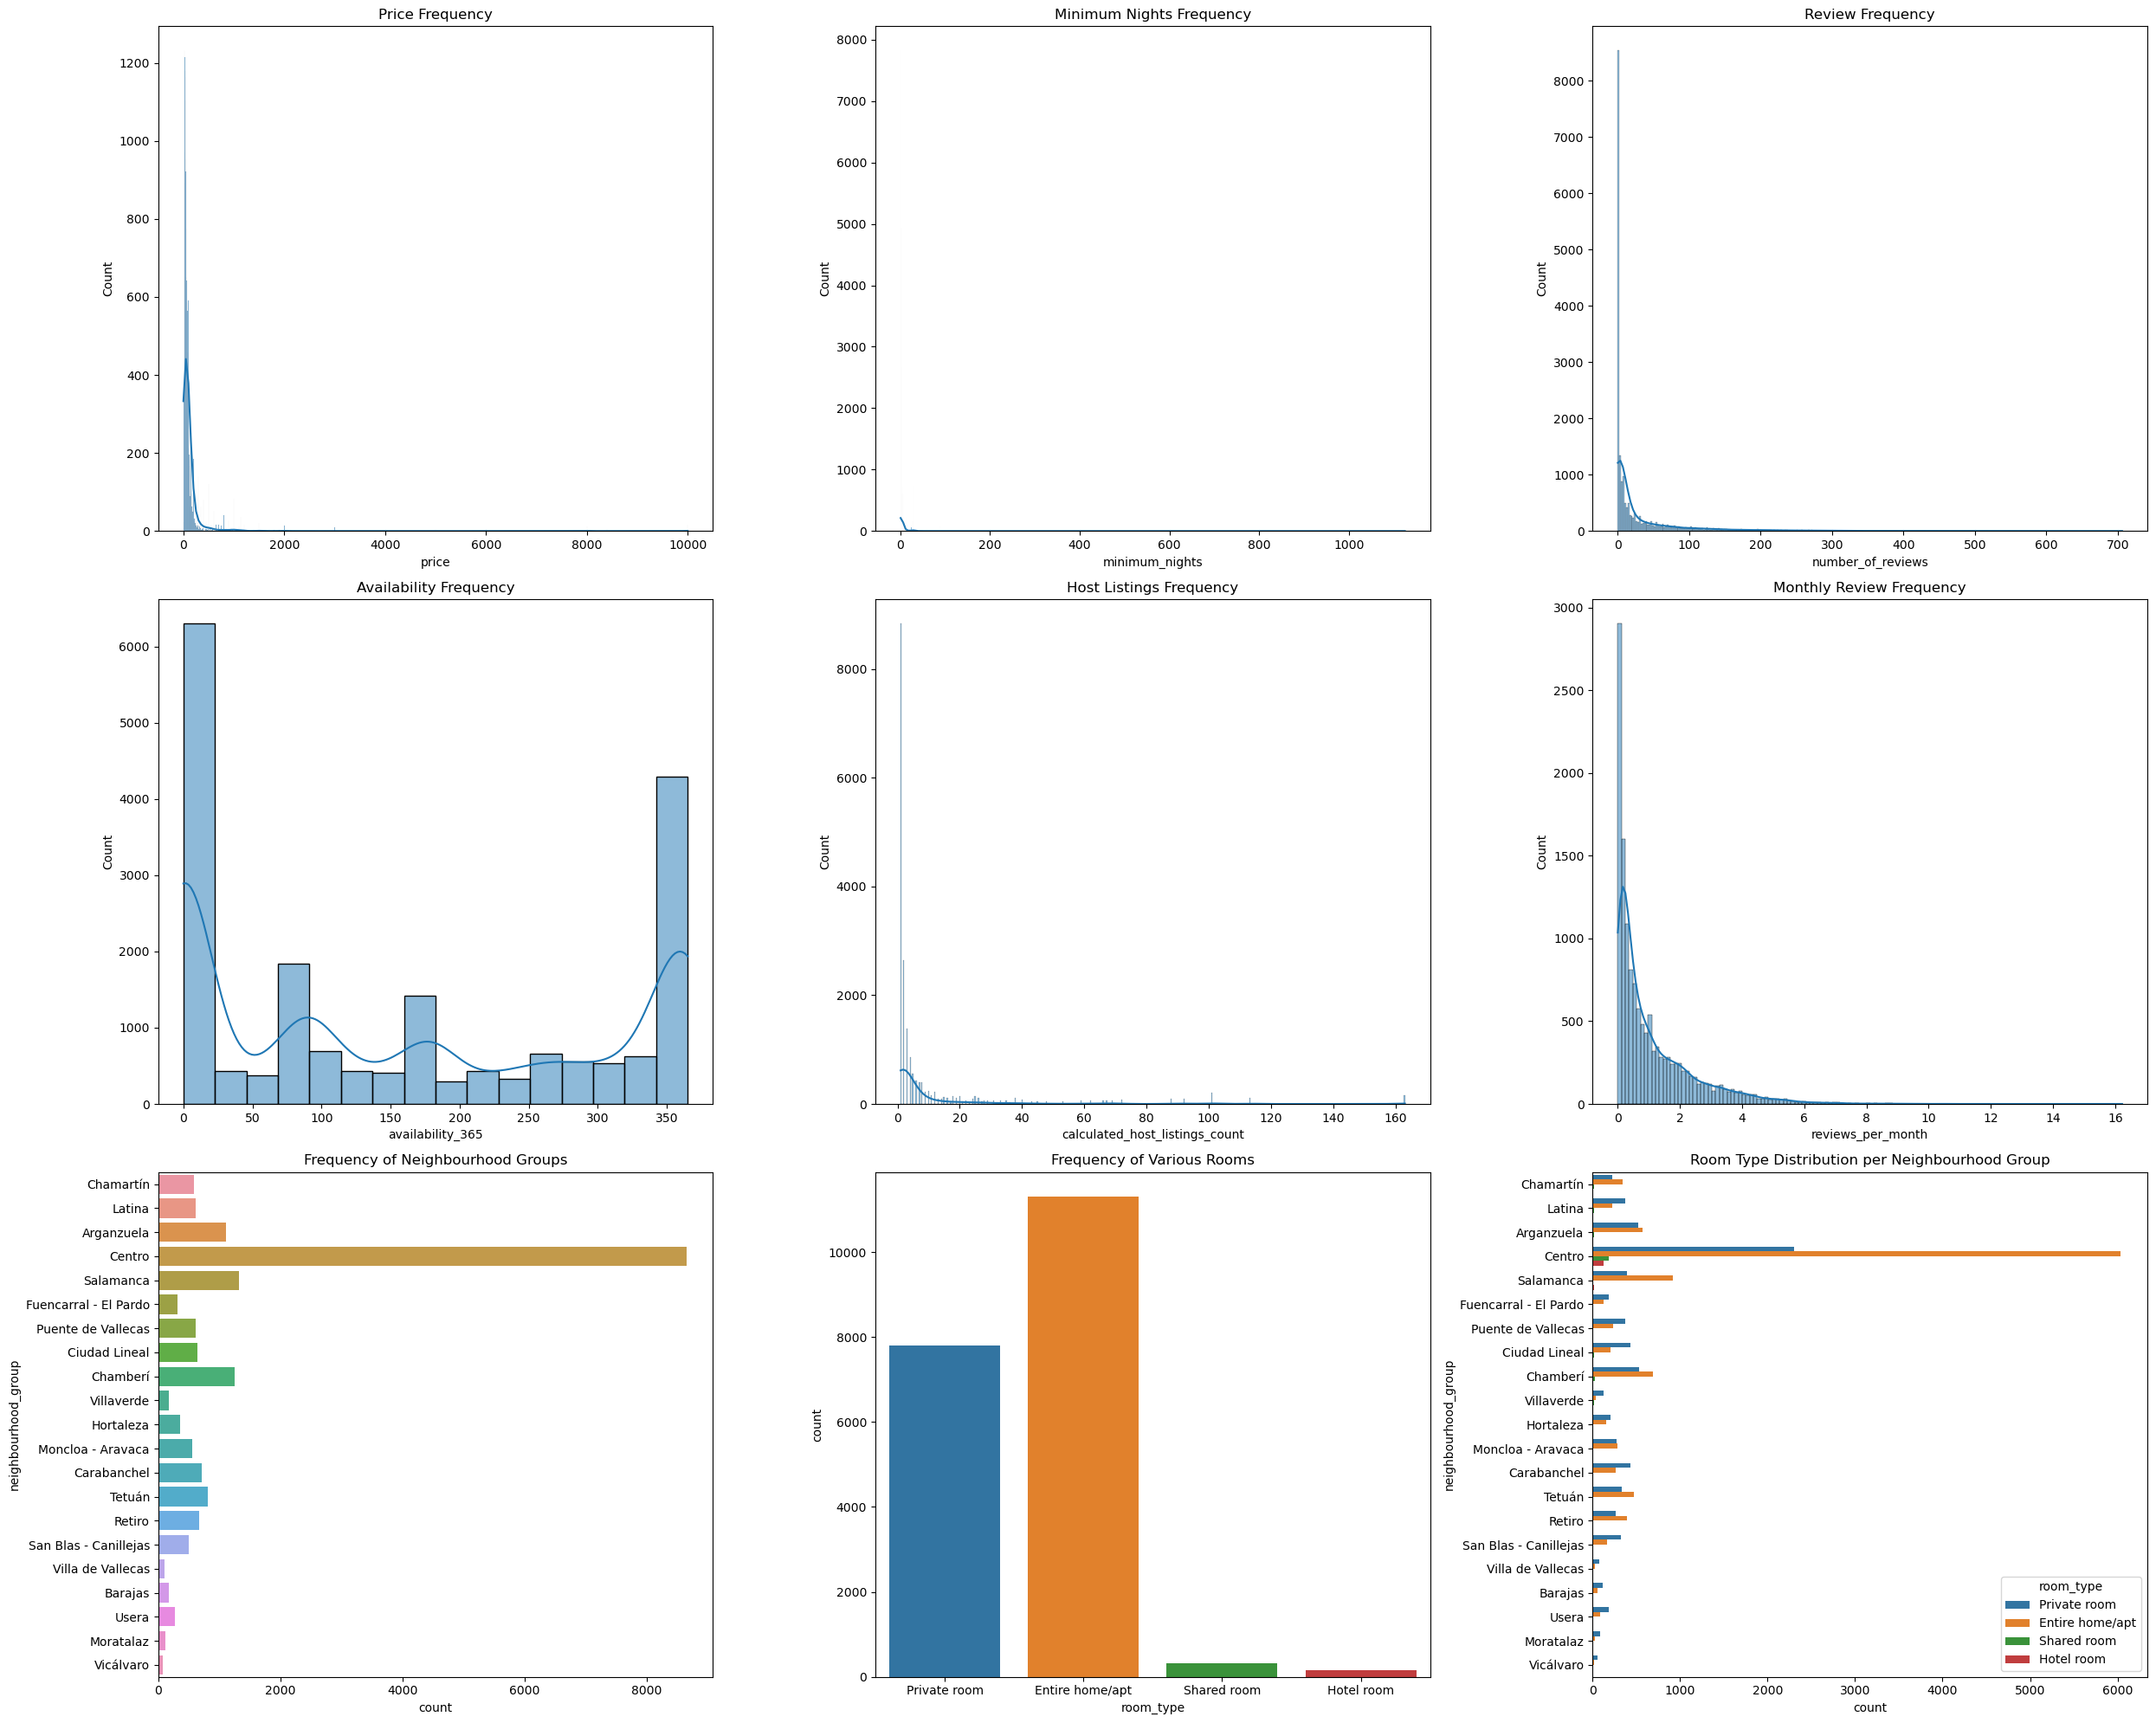

In [26]:
print_graphs(madrid_df)

#### Outlier Visualiazation

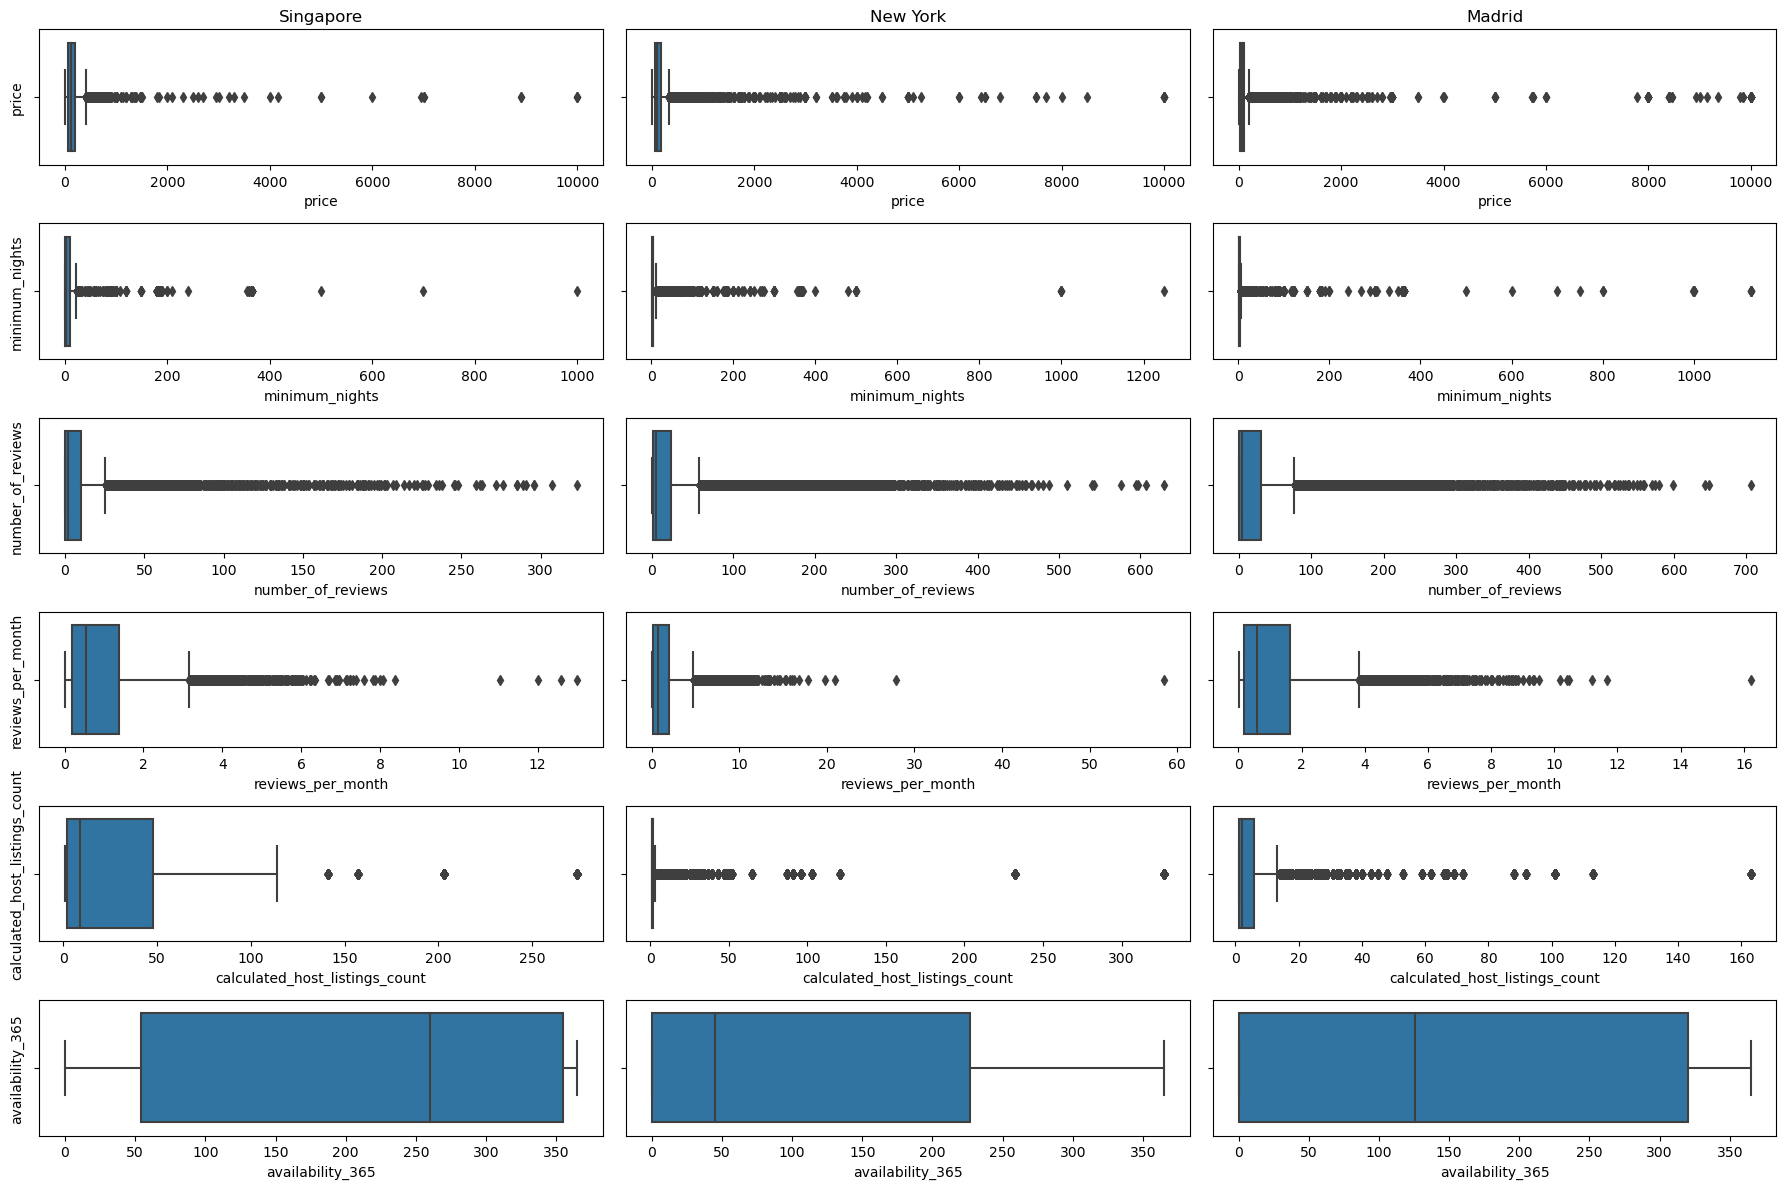

In [111]:
def outlier_visual(datasets):    
    subplotboxplot_figure, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 12))

    
    dataset_names = ['Singapore', 'New York', 'Madrid']
    features = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

    for j, dataset in enumerate(datasets):
        for i, feature in enumerate(features):
            # Plot each feature's data in the appropriate subplot
            sns.boxplot(x=dataset[feature], orient='h', ax=axes[i, j])
            if j == 0:
                # Label the rows with the feature name
                axes[i, j].set_ylabel(feature)
            if i == 0:
                # Label the columns with the dataset name
                axes[i, j].set_title(dataset_names[j])

    # Display the boxplots
    subplotboxplot_figure.tight_layout()
    subplotboxplot_figure.show()

# Visualize the outliers in the datasets
outlier_visual([singapore_df, ny_df, madrid_df])

### PCA

In [80]:
# Define the numerical and categorical features for scaling and one-hot encoding
numerical_features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_id']

# These were only chosen due to a MemoryError when trying to use all categorical features i.e. (name, host_name, last_review) since most are nearly unique
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Define preprocessing steps for both numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'   
    )

# Function to get top features from PCA components
def get_top_features(dataset):
    # Append PCA to the preprocessing pipeline, explaining 95% of the variance
    pca_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('pca', PCA(n_components=0.95))])
    pca_pipeline.fit(dataset)

    # Extract PCA components and transformed feature names
    pca = pca_pipeline.named_steps['pca']
    components = pca.components_
    transformed_feature_names = preprocessor.transformers_[0][1].named_steps['scaler'].get_feature_names_out(numerical_features).tolist() + \
                                preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()

    # Create a DataFrame of PCA components with feature names
    pca_components_df = pd.DataFrame(components, columns=transformed_feature_names)

    # Get the top 5 features for the first three components
    top_features_per_component = {}
    for i in range(5):
        top_features = pca_components_df.iloc[i].abs().nlargest(5).index.tolist()
        top_features_per_component[f'Component {i+1}'] = top_features

    return top_features_per_component

# Get the top features from PCA top 3 components for each dataset
singapore_top_features = get_top_features(singapore_df)
ny_top_features = get_top_features(ny_df)
madrid_top_features = get_top_features(madrid_df)


def get_most_frequent_features(top_features):
    all_top_features = []
    for features in [top_features]:
        for component in features.values():
            all_top_features.extend(component)

    # Get the most frequent features among all datasets
    most_frequent_features = pd.Series(all_top_features).value_counts().index.tolist()

    return most_frequent_features

# Display the top features for each dataset
singapore_most_frequent = get_most_frequent_features(singapore_top_features)
print("Singapore: Top features per PCA component:")
print(singapore_most_frequent)

ny_most_frequent = get_most_frequent_features(ny_top_features)
print("\nNew York City: Top features per PCA component:")
print(ny_most_frequent)

madrid_most_frequent = get_most_frequent_features(madrid_top_features)
print("\nMadrid: Top features per PCA component:")
print(madrid_most_frequent)



# # Combine all top features into a single list
all_top_features = []
for features in [singapore_most_frequent, ny_most_frequent, madrid_most_frequent]:
    all_top_features.extend(features)

# # Get the most frequent features among all datasets
most_frequent_features = pd.Series(all_top_features).value_counts().index.tolist()

# Display the most robust features useful for predicting Airbnb prices across all datasets
print("\nMost frequent features among all datasets:")
most_frequent_features

Singapore: Top features per PCA component:
['availability_365', 'minimum_nights', 'calculated_host_listings_count', 'longitude', 'price', 'reviews_per_month', 'latitude', 'host_id', 'number_of_reviews']

New York City: Top features per PCA component:
['host_id', 'availability_365', 'number_of_reviews', 'price', 'longitude', 'minimum_nights', 'latitude', 'reviews_per_month', 'calculated_host_listings_count', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan']

Madrid: Top features per PCA component:
['host_id', 'longitude', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group_Centro', 'latitude', 'minimum_nights', 'price', 'number_of_reviews', 'reviews_per_month', 'room_type_Private room']

Most frequent features among all datasets:


['availability_365',
 'minimum_nights',
 'calculated_host_listings_count',
 'longitude',
 'price',
 'reviews_per_month',
 'latitude',
 'host_id',
 'number_of_reviews',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Centro',
 'room_type_Private room']

In [89]:
# Calculate metrics
def calculate_metrics(y_test, y_pred):   
    rmse = mean_squared_error(y_test, y_pred, squared=False)    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2


# Preprocessor
def get_preprocessor():    
    # Defining preprocessing for numeric columns
    numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_id']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Defining preprocessing for categorical columns
    categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combining preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)        
        ],
        remainder='drop'
    )
    
    return preprocessor    

# Models

# Random Forest
def random_forest_model(preprocessor):
    rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])
    return rf_pipeline

# Linear Regression
def linear_regression_model(preprocessor):
    lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])
    return lr_pipeline

# XGBoost
def xgboost_model(preprocessor):
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(random_state=42))])
    return xgb_pipeline

# Model Prediction
def get_prediction(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

preprocessor = get_preprocessor()
rf_model = random_forest_model(preprocessor)
lr_model = linear_regression_model(preprocessor)
xg_model = xgboost_model(preprocessor)

def get_X_y(df):      
    X = df.drop('price', axis=1)
    y = df['price']
    return X, y   


### Baseline Preprocessing

In [52]:


singapore_X, singapore_y = get_X_y(singapore_df)
ny_X, ny_y = get_X_y(ny_df) 
madrid_X, madrid_y = get_X_y(madrid_df)

# Split the data into training and testing sets
singapore_X_train, singapore_X_test, singapore_y_train, singapore_y_test = train_test_split(singapore_X, singapore_y, test_size=0.3, random_state=42)
ny_X_train, ny_X_test, ny_y_train, ny_y_test = train_test_split(ny_X, ny_y, test_size=0.3, random_state=42)
madrid_X_train, madrid_X_test, madrid_y_train, madrid_y_test = train_test_split(madrid_X, madrid_y, test_size=0.3, random_state=42)

#### Results

In [53]:
# Metrics per city

# Singapore
singapore_rf_rmse, singapore_rf_mae, singapore_rf_r2 = calculate_metrics(singapore_y_test, get_prediction(singapore_X_train, singapore_y_train, singapore_X_test, rf_model))
singapore_lr_rmse, singapore_lr_mae, singapore_lr_r2 = calculate_metrics(singapore_y_test, get_prediction(singapore_X_train, singapore_y_train, singapore_X_test, lr_model))
singapore_xg_rmse, singapore_xg_mae, singapore_xg_r2 = calculate_metrics(singapore_y_test, get_prediction(singapore_X_train, singapore_y_train, singapore_X_test, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {singapore_rf_rmse}, MAE: {singapore_rf_mae}, R2: {singapore_rf_r2}")
print(f"Linear Regression: RSME: {singapore_lr_rmse}, MAE: {singapore_lr_mae}, R2: {singapore_lr_r2}")
print(f"XGBoost: RSME: {singapore_xg_rmse}, MAE: {singapore_xg_mae}, R2: {singapore_xg_r2}")


# NY
ny_rf_rmse, ny_rf_mae, ny_rf_r2 = calculate_metrics(ny_y_test, get_prediction(ny_X_train, ny_y_train, ny_X_test, rf_model))
ny_lr_rmse, ny_lr_mae, ny_lr_r2 = calculate_metrics(ny_y_test, get_prediction(ny_X_train, ny_y_train, ny_X_test, lr_model))
ny_xg_rmse, ny_xg_mae, ny_xg_r2 = calculate_metrics(ny_y_test, get_prediction(ny_X_train, ny_y_train, ny_X_test, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {ny_rf_rmse}, MAE: {ny_rf_mae}, R2: {ny_rf_r2}")
print(f"Linear Regression: RSME: {ny_lr_rmse}, MAE: {ny_lr_mae}, R2: {ny_lr_r2}")
print(f"XGBoost: RSME: {ny_xg_rmse}, MAE: {ny_xg_mae}, R2: {ny_xg_r2}")


# Madrid
madrid_rf_rmse, madrid_rf_mae, madrid_rf_r2 = calculate_metrics(madrid_y_test, get_prediction(madrid_X_train, madrid_y_train, madrid_X_test, rf_model))
madrid_lr_rmse, madrid_lr_mae, madrid_lr_r2 = calculate_metrics(madrid_y_test, get_prediction(madrid_X_train, madrid_y_train, madrid_X_test, lr_model))
madrid_xg_rmse, madrid_xg_mae, madrid_xg_r2 = calculate_metrics(madrid_y_test, get_prediction(madrid_X_train, madrid_y_train, madrid_X_test, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {madrid_rf_rmse}, MAE: {madrid_rf_mae}, R2: {madrid_rf_r2}")
print(f"Linear Regression: RSME: {madrid_lr_rmse}, MAE: {madrid_lr_mae}, R2: {madrid_lr_r2}")
print(f"XGBoost: RSME: {madrid_xg_rmse}, MAE: {madrid_xg_mae}, R2: {madrid_xg_r2}")

Singapore:
Random Forest Regressor: RSME: 318.3675876381475, MAE: 78.51499789296251, R2: -0.5789507214842913
Linear Regression: RSME: 248.55128767569806, MAE: 84.63085020135377, R2: 0.03762813569972556
XGBoost: RSME: 297.60396761446606, MAE: 80.77734311561116, R2: -0.37971160242199997

NY:
Random Forest Regressor: RSME: 186.86384193137766, MAE: 63.641637434304286, R2: 0.135419085923559
Linear Regression: RSME: 185.14961134870808, MAE: 69.2041437614632, R2: 0.15120911687280636
XGBoost: RSME: 189.5524102276411, MAE: 65.47197646044442, R2: 0.11036119375373266

Madrid:
Random Forest Regressor: RSME: 515.677156598528, MAE: 112.08109883419898, R2: 0.006363254448856548
Linear Regression: RSME: 514.3569318789458, MAE: 124.25116604697126, R2: 0.011444513242432452
XGBoost: RSME: 545.3060386010403, MAE: 129.84047555165492, R2: -0.11109826820496416


### Improved Preprocessing - Log Transformation

Strategy Taken: 
 - Log Transformation on the 'price' column done to manage outliers and reduce skewness.

In [81]:
def get_X_y_log(df):
     # Log transformation to manage outliers in the 'price' column
     t_df = df.copy()
     log_transformer = FunctionTransformer(np.log1p, validate=True)
     t_df['log_price'] = log_transformer.transform(t_df[['price']])
     X = t_df.drop(['price', 'log_price'], axis=1)
     y_log = t_df['log_price'] 
     return X, y_log

# Undo the log transformation
def undo_log_transform(y_log):
    return np.expm1(y_log)

singapore_X_improved, singapore_y_improved = get_X_y_log(singapore_df)
ny_X_improved, ny_y_improved = get_X_y_log(ny_df)
madrid_X_improved, madrid_y_improved = get_X_y_log(madrid_df)

# Split the data into training and testing sets
singapore_X_train_imp, singapore_X_test_imp, singapore_y_train_imp, singapore_y_test_imp = train_test_split(singapore_X_improved, singapore_y_improved, test_size=0.3, random_state=42)
ny_X_train_imp, ny_X_test_imp, ny_y_train_imp, ny_y_test_imp = train_test_split(ny_X_improved, ny_y_improved, test_size=0.3, random_state=42)
madrid_X_train_imp, madrid_X_test_imp, madrid_y_train_imp, madrid_y_test_imp = train_test_split(madrid_X_improved, madrid_y_improved, test_size=0.3, random_state=42)

In [82]:
singapore_y_pred_rf = undo_log_transform(get_prediction(singapore_X_train_imp, singapore_y_train_imp.ravel(), singapore_X_test_imp, rf_model))
singapore_y_pred_lr = undo_log_transform(get_prediction(singapore_X_train_imp, singapore_y_train_imp.ravel(), singapore_X_test_imp, lr_model))
singapore_y_pred_xg = undo_log_transform(get_prediction(singapore_X_train_imp, singapore_y_train_imp.ravel(), singapore_X_test_imp, xg_model))

ny_y_pred_rf = undo_log_transform(get_prediction(ny_X_train_imp, ny_y_train_imp.ravel(), ny_X_test_imp, rf_model))
ny_y_pred_lr = undo_log_transform(get_prediction(ny_X_train_imp, ny_y_train_imp.ravel(), ny_X_test_imp, lr_model))
ny_y_pred_xg = undo_log_transform(get_prediction(ny_X_train_imp, ny_y_train_imp.ravel(), ny_X_test_imp, xg_model))

madrid_y_pred_rf = undo_log_transform(get_prediction(madrid_X_train_imp, madrid_y_train_imp.ravel(), madrid_X_test_imp, rf_model))
madrid_y_pred_lr = undo_log_transform(get_prediction(madrid_X_train_imp, madrid_y_train_imp.ravel(), madrid_X_test_imp, lr_model))
madrid_y_pred_xg = undo_log_transform(get_prediction(madrid_X_train_imp, madrid_y_train_imp.ravel(), madrid_X_test_imp, xg_model))

singapore_y_test_imp = undo_log_transform(singapore_y_test_imp)
ny_y_test_imp = undo_log_transform(ny_y_test_imp)
madrid_y_test_imp = undo_log_transform(madrid_y_test_imp)


#Regression models for each city
# Singapore
rf_rmse, rf_mae, rf_r2 = calculate_metrics(singapore_y_test_imp, singapore_y_pred_rf)
lr_rmse, lr_mae, lr_r2 = calculate_metrics(singapore_y_test_imp, singapore_y_pred_lr)
xg_rmse, xg_mae, xg_r2 = calculate_metrics(singapore_y_test_imp, singapore_y_pred_xg)


print("Singapore")
print(f'Random Forest Regressor RMSE: {rf_rmse}, MAE: {rf_mae}', f'R2: {rf_r2}')
print(f'Linear Regression RMSE: {lr_rmse}, MAE: {lr_mae}', f'R2: {lr_r2}')
print(f'XGBoost RMSE: {xg_rmse}, MAE: {xg_mae}', f'R2: {xg_r2}')


# New York
rf_rmse, rf_mae, rf_r2 = calculate_metrics(ny_y_test_imp, ny_y_pred_rf)
lr_rmse, lr_mae, lr_r2 = calculate_metrics(ny_y_test_imp, ny_y_pred_lr)
xg_rmse, xg_mae, xg_r2 = calculate_metrics(ny_y_test_imp, ny_y_pred_xg)

print("\nNew York")
print(f'Random Forest Regressor RMSE: {rf_rmse}, MAE: {rf_mae}', f'R2: {rf_r2}')
print(f'Linear Regression RMSE: {lr_rmse}, MAE: {lr_mae}', f'R2: {lr_r2}')
print(f'XGBoost RMSE: {xg_rmse}, MAE: {xg_mae}', f'R2: {xg_r2}')


# Madrid
rf_rmse, rf_mae, rf_r2 = calculate_metrics(madrid_y_test_imp, madrid_y_pred_rf)
lr_rmse, lr_mae, lr_r2 = calculate_metrics(madrid_y_test_imp, madrid_y_pred_lr)
xg_rmse, xg_mae, xg_r2 = calculate_metrics(madrid_y_test_imp, madrid_y_pred_xg)

print("\nMadrid")
print(f'Random Forest Regressor RMSE: {rf_rmse}, MAE: {rf_mae}', f'R2: {rf_r2}')
print(f'Linear Regression RMSE: {lr_rmse}, MAE: {lr_mae}', f'R2: {lr_r2}')
print(f'XGBoost RMSE: {xg_rmse}, MAE: {xg_mae}', f'R2: {xg_r2}')

Singapore
Random Forest Regressor RMSE: 243.9911278208981, MAE: 66.53524154954678 R2: 0.07261738184451894
Linear Regression RMSE: 256.30582894069465, MAE: 89.75430162833187 R2: -0.02335861238257597
XGBoost RMSE: 243.83587885120647, MAE: 69.46047345164251 R2: 0.07379717385022089

New York
Random Forest Regressor RMSE: 190.2623267234005, MAE: 69.02682680077167 R2: 0.10368491939059554
Linear Regression RMSE: 200.1676713830641, MAE: 76.30456502925485 R2: 0.007928506905683586
XGBoost RMSE: 190.95842654172898, MAE: 69.38915990334979 R2: 0.0971143477901496

Madrid
Random Forest Regressor RMSE: 513.1399982989755, MAE: 91.2049201667741 R2: 0.016116690002701772
Linear Regression RMSE: 521.9001323146284, MAE: 97.67275698269522 R2: -0.017763028676879733
XGBoost RMSE: 509.67789905638006, MAE: 92.68184900494447 R2: 0.029348208504044848


### Improved Preprocessing - Price Outlier Removal
Strategy Taken:
 - Drop rows above the upper bound outlier or below the lower bound outlier
 - Done since the amount of outliers for each dataset was below 10%

In [83]:
# Function to count outliers and calculate percentages
def outliers_stats(df):
    # Calculate Q1 and Q3
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count rows with prices above upper bound
    above_upper_limit = df[df['price'] > upper_bound].shape[0]
    # Count rows with prices below lower bound
    below_lower_limit = df[df['price'] < lower_bound].shape[0]

    # Calculate percentages based on the original DataFrame's row count
    total_rows = df.shape[0]
    percentage_above = (above_upper_limit / total_rows) * 100
    percentage_below = (below_lower_limit / total_rows) * 100

    return {
        "Total Rows": total_rows,
        "Above Upper Limit Count": above_upper_limit,
        "Below Lower Limit Count": below_lower_limit,
        "Size After Removing Outliers": total_rows - above_upper_limit - below_lower_limit,
        "Percentage Above Upper Limit": f"{percentage_above:.2f}%",
        "Percentage Below Lower Limit": f"{percentage_below:.2f}%"
    }

print("Singapore",outliers_stats(singapore_df))
print("NY",outliers_stats(ny_df))
print("Madrid",outliers_stats(madrid_df))

Singapore {'Total Rows': 7907, 'Above Upper Limit Count': 324, 'Below Lower Limit Count': 0, 'Size After Removing Outliers': 7583, 'Percentage Above Upper Limit': '4.10%', 'Percentage Below Lower Limit': '0.00%'}
NY {'Total Rows': 48895, 'Above Upper Limit Count': 2972, 'Below Lower Limit Count': 0, 'Size After Removing Outliers': 45923, 'Percentage Above Upper Limit': '6.08%', 'Percentage Below Lower Limit': '0.00%'}
Madrid {'Total Rows': 19618, 'Above Upper Limit Count': 1905, 'Below Lower Limit Count': 0, 'Size After Removing Outliers': 17713, 'Percentage Above Upper Limit': '9.71%', 'Percentage Below Lower Limit': '0.00%'}


In [92]:
def drop_target_oultiers(df):

    transformed_df = df.copy()
    Q1 = transformed_df['price'].quantile(0.25)
    Q3 = transformed_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the outliers
    transformed_df.drop(transformed_df[(transformed_df['price'] > upper_bound) | (transformed_df['price'] < lower_bound)].index, inplace=True)
    return transformed_df

In [93]:

singapore_drop_target_outliers = drop_target_oultiers(singapore_df)
ny_drop_target_outliers = drop_target_oultiers(ny_df)
madrid_drop_target_outliers = drop_target_oultiers(madrid_df)

singapore_X_improvedv2, singapore_y_improvedv2 = get_X_y(singapore_drop_target_outliers)
ny_X_improvedv2, ny_y_improvedv2 = get_X_y(ny_drop_target_outliers)
madrid_X_improvedv2, madrid_y_improvedv2 = get_X_y(madrid_drop_target_outliers)

# Split the data into training and testing sets
singapore_X_train_impv2, singapore_X_test_impv2, singapore_y_train_impv2, singapore_y_test_impv2 = train_test_split(singapore_X_improvedv2, singapore_y_improvedv2, test_size=0.3, random_state=42)
ny_X_train_impv2, ny_X_test_impv2, ny_y_train_impv2, ny_y_test_impv2 = train_test_split(ny_X_improvedv2, ny_y_improvedv2, test_size=0.3, random_state=42)
madrid_X_train_impv2, madrid_X_test_impv2, madrid_y_train_impv2, madrid_y_test_impv2 = train_test_split(madrid_X_improvedv2, madrid_y_improvedv2, test_size=0.3, random_state=42)


#### Target Outlier Visual after Removal

Singapore
Before: 7907, After: 7583


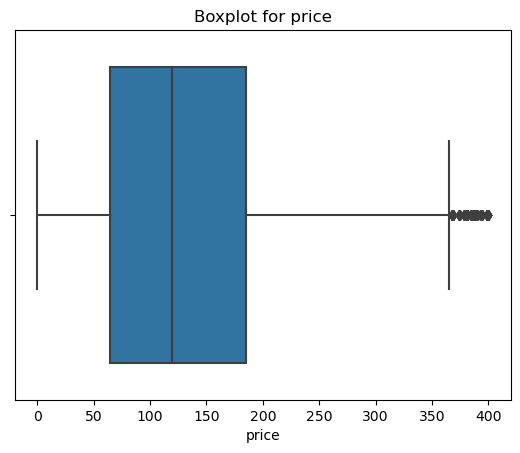

NY
Before: 48895, After: 45923


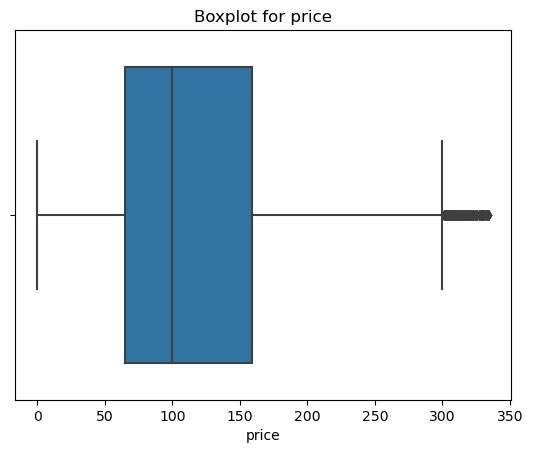

Madrid
Before: 19618, After: 17713


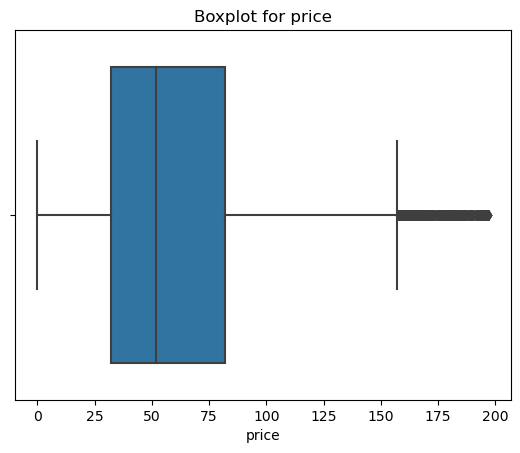

In [86]:
print("Singapore")
print(f"Before: {singapore_df.shape[0]}, After: {singapore_drop_target_outliers.shape[0]}")
print_outliers(singapore_drop_target_outliers, ['price'])

print("NY")
print(f"Before: {ny_df.shape[0]}, After: {ny_drop_target_outliers.shape[0]}")
print_outliers(ny_drop_target_outliers, ['price'])


print("Madrid")
print(f"Before: {madrid_df.shape[0]}, After: {madrid_drop_target_outliers.shape[0]}")
print_outliers(madrid_drop_target_outliers, ['price'])

#### Results

In [94]:
singapore_rf_rmse, singapore_rf_mae, singapore_rf_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, rf_model))
singapore_lr_rmse, singapore_lr_mae, singapore_lr_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, lr_model))
singapore_xg_rmse, singapore_xg_mae, singapore_xg_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, xg_model))


# Singapore
print("Singapore:")
print(f"Random Forest Regressor: RSME: {singapore_rf_rmse}, MAE: {singapore_rf_mae}, R2: {singapore_rf_r2}")
print(f"Linear Regression: RSME: {singapore_lr_rmse}, MAE: {singapore_lr_mae}, R2: {singapore_lr_r2}")
print(f"XGBoost: RSME: {singapore_xg_rmse}, MAE: {singapore_xg_mae}, R2: {singapore_xg_r2}")


# NY
ny_rf_rmse, ny_rf_mae, ny_rf_r2 = calculate_metrics(ny_y_test_impv2, get_prediction(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, rf_model))
ny_lr_rmse, ny_lr_mae, ny_lr_r2 = calculate_metrics(ny_y_test_impv2, get_prediction(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, lr_model))
ny_xg_rmse, ny_xg_mae, ny_xg_r2 = calculate_metrics(ny_y_test_impv2, get_prediction(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {ny_rf_rmse}, MAE: {ny_rf_mae}, R2: {ny_rf_r2}")
print(f"Linear Regression: RSME: {ny_lr_rmse}, MAE: {ny_lr_mae}, R2: {ny_lr_r2}")
print(f"XGBoost: RSME: {ny_xg_rmse}, MAE: {ny_xg_mae}, R2: {ny_xg_r2}")


# Madrid
madrid_rf_rmse, madrid_rf_mae, madrid_rf_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, rf_model))
madrid_lr_rmse, madrid_lr_mae, madrid_lr_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, lr_model)) 
madrid_xg_rmse, madrid_xg_mae, madrid_xg_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {madrid_rf_rmse}, MAE: {madrid_rf_mae}, R2: {madrid_rf_r2}")
print(f"Linear Regression: RSME: {madrid_lr_rmse}, MAE: {madrid_lr_mae}, R2: {madrid_lr_r2}")
print(f"XGBoost: RSME: {madrid_xg_rmse}, MAE: {madrid_xg_mae}, R2: {madrid_xg_r2}")

Singapore:
Random Forest Regressor: RSME: 48.305815397638916, MAE: 33.28136263736264, R2: 0.6777994792866007
Linear Regression: RSME: 62.20980320001483, MAE: 47.519269828701894, R2: 0.46562632139027804
XGBoost: RSME: 49.71600348954791, MAE: 34.76775409572727, R2: 0.6587129394422511

NY:
Random Forest Regressor: RSME: 44.81268416334889, MAE: 31.940993443178243, R2: 0.5663689577171415
Linear Regression: RSME: 47.31471331797534, MAE: 34.540699982029665, R2: 0.516595293037908
XGBoost: RSME: 44.42838322192682, MAE: 31.846479951534977, R2: 0.573774462270006

Madrid:
Random Forest Regressor: RSME: 28.559464974478296, MAE: 20.135753346954136, R2: 0.47849466864600243
Linear Regression: RSME: 31.83284620982506, MAE: 23.172527386703887, R2: 0.3520976422793036
XGBoost: RSME: 28.885838483351815, MAE: 20.552626337762117, R2: 0.46650718447403716


### Furthur Improvements on Removing Price Outliers

#### Imbalanced Data Management
As seen in the EDA the data is imbalanced in terms of the features neighbourhood_group and room_type\

Strategy:
- Stratified Sampling

#### Outlier Management
Numerous outliers present in other numeric features as visualized in the EDA may be influencing price prediction\
Such features are 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count'\

Strategies:
- Outlier Capping
- Log Transformation
- Outlier Removal

#### Stratified Sampling

In [95]:
def get_X_y_stratified(df):
    data = df.copy()
    data['stratify_col'] = data['neighbourhood_group'] + "_" + data['room_type']
    combo_counts = data['stratify_col'].value_counts()
    data = data[data['stratify_col'].isin(combo_counts[combo_counts > 1].index)]
    X = data.drop(['price', 'stratify_col'], axis=1)  # Also drop the stratify_col after using it for filtering
    y = data['price']
    return X, y, data['stratify_col']


singapore_drop_target_outliers = drop_target_oultiers(singapore_df)
ny_drop_target_outliers = drop_target_oultiers(ny_df)
madrid_drop_target_outliers = drop_target_oultiers(madrid_df)

singapore_X_strat, singapore_y_strat, sing_strat_col = get_X_y_stratified(singapore_drop_target_outliers)
ny_X_strat, ny_y_strat, ny_strat_col = get_X_y_stratified(ny_drop_target_outliers)
madrid_X_strat, madrid_y_strat, mad_strat_col = get_X_y_stratified(madrid_drop_target_outliers)

# Split the data into training and testing sets
singapore_X_train_strat, singapore_X_test_strat, singapore_y_train_strat, singapore_y_test_strat = train_test_split(singapore_X_strat, singapore_y_strat, test_size=0.3, random_state=42, stratify=sing_strat_col)
ny_X_train_strat, ny_X_test_strat, ny_y_train_strat, ny_y_test_strat = train_test_split(ny_X_strat, ny_y_strat, test_size=0.3, random_state=42, stratify=ny_strat_col)
madrid_X_train_strat, madrid_X_test_strat, madrid_y_train_strat, madrid_y_test_strat = train_test_split(madrid_X_strat, madrid_y_strat, test_size=0.3, random_state=42, stratify=mad_strat_col)

In [96]:
# Singapore
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_strat, get_prediction(singapore_X_train_strat, singapore_y_train_strat, singapore_X_test_strat, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_strat, get_prediction(singapore_X_train_strat, singapore_y_train_strat, singapore_X_test_strat, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_strat, get_prediction(singapore_X_train_strat, singapore_y_train_strat, singapore_X_test_strat, xg_model))

print("Singapore")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

# NY
rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_strat, get_prediction(ny_X_train_strat, ny_y_train_strat, ny_X_test_strat, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_strat, get_prediction(ny_X_train_strat, ny_y_train_strat, ny_X_test_strat, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_strat, get_prediction(ny_X_train_strat, ny_y_train_strat, ny_X_test_strat, xg_model))

print("\nNY")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

# Madrid
rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_strat, get_prediction(madrid_X_train_strat, madrid_y_train_strat, madrid_X_test_strat, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_strat, get_prediction(madrid_X_train_strat, madrid_y_train_strat, madrid_X_test_strat, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_strat, get_prediction(madrid_X_train_strat, madrid_y_train_strat, madrid_X_test_strat, xg_model))

print("\nMadrid")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore
Random Forest Regressor: RSME: 49.112835024378995, MAE: 33.5352967032967, R2: 0.6707761032821278
Linear Regression: RSME: 62.01892927882177, MAE: 46.98263977854211, R2: 0.4750114029926773
XGBoost: RSME: 50.17266346869099, MAE: 35.055636567126264, R2: 0.6564138449507588

NY
Random Forest Regressor: RSME: 44.1733759317347, MAE: 31.58346955070044, R2: 0.5812596664801308
Linear Regression: RSME: 46.69151620526744, MAE: 34.07215659939852, R2: 0.5321576139801976
XGBoost: RSME: 44.0780373628724, MAE: 31.560792252141244, R2: 0.5830652347310163

Madrid
Random Forest Regressor: RSME: 29.10661954752224, MAE: 20.467381830895008, R2: 0.47268229201996437
Linear Regression: RSME: 32.25695733840665, MAE: 23.475981688737956, R2: 0.35235708795987597
XGBoost: RSME: 29.412268842731592, MAE: 20.82912942317752, R2: 0.4615493926456138


In [97]:
numeric_features_ = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

### Outlier Capping

In [98]:
# 1. Outlier Capping

def cap_outliers(df):
    transformed_df = df.copy()
    for feature in numeric_features_:
        Q1 = transformed_df[feature].quantile(0.25)
        Q3 = transformed_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        transformed_df.loc[transformed_df[feature] < lower_bound, feature] = lower_bound
        transformed_df.loc[transformed_df[feature] > upper_bound, feature] = upper_bound
    return transformed_df



singapore_df_capped = cap_outliers(drop_target_oultiers(singapore_df))
ny_df_capped = cap_outliers(drop_target_oultiers(ny_df))
madrid_df_capped = cap_outliers(drop_target_oultiers(madrid_df))


singapore_X_capped, singapore_y_capped = get_X_y(singapore_df_capped)
ny_X_capped, ny_y_capped = get_X_y(ny_df_capped)
madrid_X_capped, madrid_y_capped = get_X_y(madrid_df_capped)

# Split the data into training and testing sets
singapore_X_train_capped, singapore_X_test_capped, singapore_y_train_capped, singapore_y_test_capped = train_test_split(singapore_X_capped, singapore_y_capped, test_size=0.3, random_state=42)
ny_X_train_capped, ny_X_test_capped, ny_y_train_capped, ny_y_test_capped = train_test_split(ny_X_capped, ny_y_capped, test_size=0.3, random_state=42)
madrid_X_train_capped, madrid_X_test_capped, madrid_y_train_capped, madrid_y_test_capped = train_test_split(madrid_X_capped, madrid_y_capped, test_size=0.3, random_state=42)



#### Outliers Visual After Capping

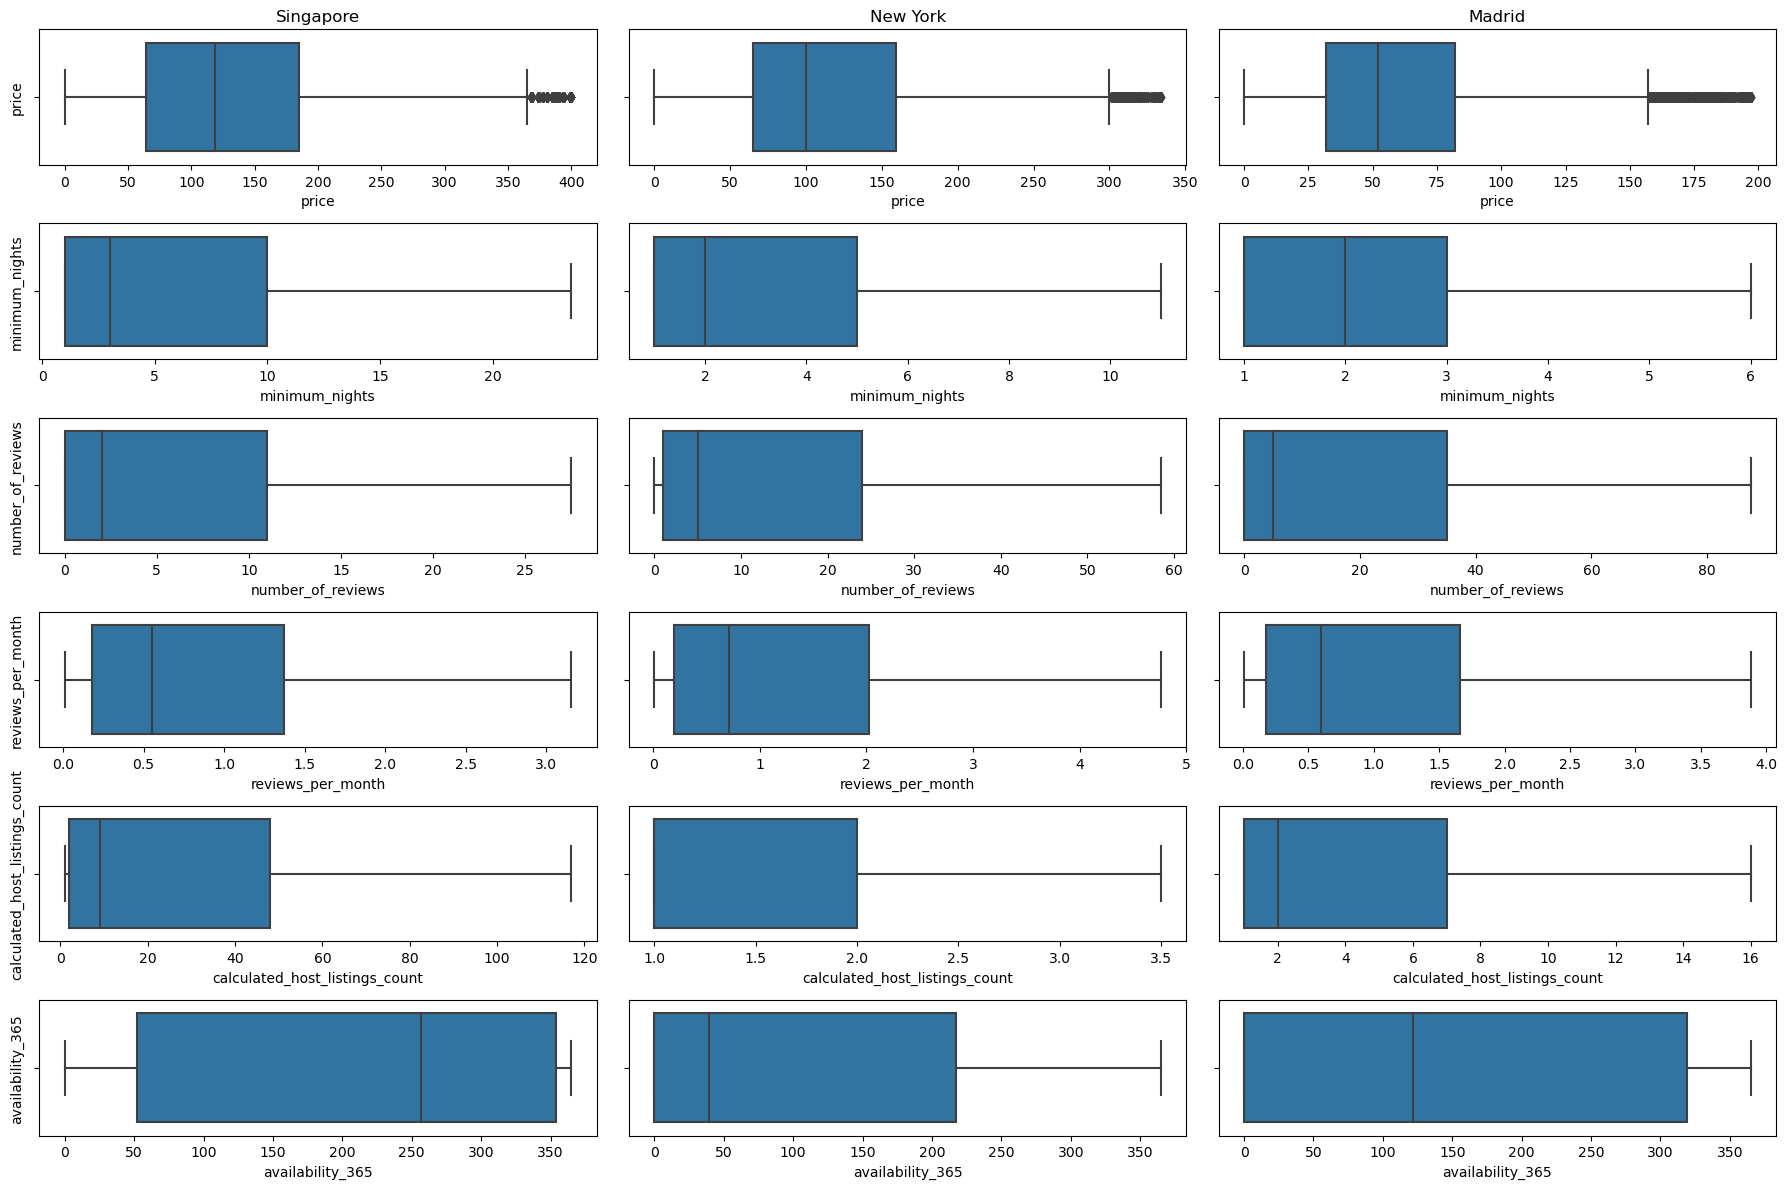

In [112]:
outlier_visual([singapore_df_capped, ny_df_capped, madrid_df_capped])

#### Results

In [100]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_capped, get_prediction(singapore_X_train_capped, singapore_y_train_capped, singapore_X_test_capped, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_capped, get_prediction(singapore_X_train_capped, singapore_y_train_capped, singapore_X_test_capped, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_capped, get_prediction(singapore_X_train_capped, singapore_y_train_capped, singapore_X_test_capped, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_capped, get_prediction(ny_X_train_capped, ny_y_train_capped, ny_X_test_capped, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_capped, get_prediction(ny_X_train_capped, ny_y_train_capped, ny_X_test_capped, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_capped, get_prediction(ny_X_train_capped, ny_y_train_capped, ny_X_test_capped, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_capped, get_prediction(madrid_X_train_capped, madrid_y_train_capped, madrid_X_test_capped, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_capped, get_prediction(madrid_X_train_capped, madrid_y_train_capped, madrid_X_test_capped, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_capped, get_prediction(madrid_X_train_capped, madrid_y_train_capped, madrid_X_test_capped, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore:
Random Forest Regressor: RSME: 48.19953082668013, MAE: 33.214, R2: 0.6792157588882228
Linear Regression: RSME: 61.258487114270146, MAE: 46.518721642254114, R2: 0.48184470908820587
XGBoost: RSME: 49.672471507050254, MAE: 34.642118176470746, R2: 0.6593103486004932

NY:
Random Forest Regressor: RSME: 44.82931299452051, MAE: 31.984839950642375, R2: 0.5660470794188743
Linear Regression: RSME: 46.92992245014906, MAE: 34.26144347670169, R2: 0.52442597968543
XGBoost: RSME: 44.52751364500168, MAE: 31.944390006894995, R2: 0.5718703166803925

Madrid:
Random Forest Regressor: RSME: 28.76747120776819, MAE: 20.267631642382206, R2: 0.4708704788438123
Linear Regression: RSME: 31.73381728108497, MAE: 23.088288147970214, R2: 0.3561224961372489
XGBoost: RSME: 29.335137526740343, MAE: 20.85952422392965, R2: 0.44978189690199544


### Outlier Log Transformation

In [114]:
# 2. Log Transformation
def apply_log_transformation(df):
    log_transform = FunctionTransformer(np.log1p)
    transformed_df = df.copy()
    
    for feature in numeric_features_:
        transformed_df[feature] = log_transform.fit_transform(df[[feature]])
    return transformed_df

singapore_df_log = apply_log_transformation(drop_target_oultiers(singapore_df))
ny_df_log = apply_log_transformation(drop_target_oultiers(ny_df))
madrid_df_log = apply_log_transformation(drop_target_oultiers(madrid_df))

singapore_X_log, singapore_y_log = get_X_y(singapore_df_log)
ny_X_log, ny_y_log = get_X_y(ny_df_log)
madrid_X_log, madrid_y_log = get_X_y(madrid_df_log)

# Split the data into training and testing sets
singapore_X_train_log, singapore_X_test_log, singapore_y_train_log, singapore_y_test_log = train_test_split(singapore_X_log, singapore_y_log, test_size=0.3, random_state=42)
ny_X_train_log, ny_X_test_log, ny_y_train_log, ny_y_test_log = train_test_split(ny_X_log, ny_y_log, test_size=0.3, random_state=42)
madrid_X_train_log, madrid_X_test_log, madrid_y_train_log, madrid_y_test_log = train_test_split(madrid_X_log, madrid_y_log, test_size=0.3, random_state=42)

#### Outlier Visual After Log Transformation

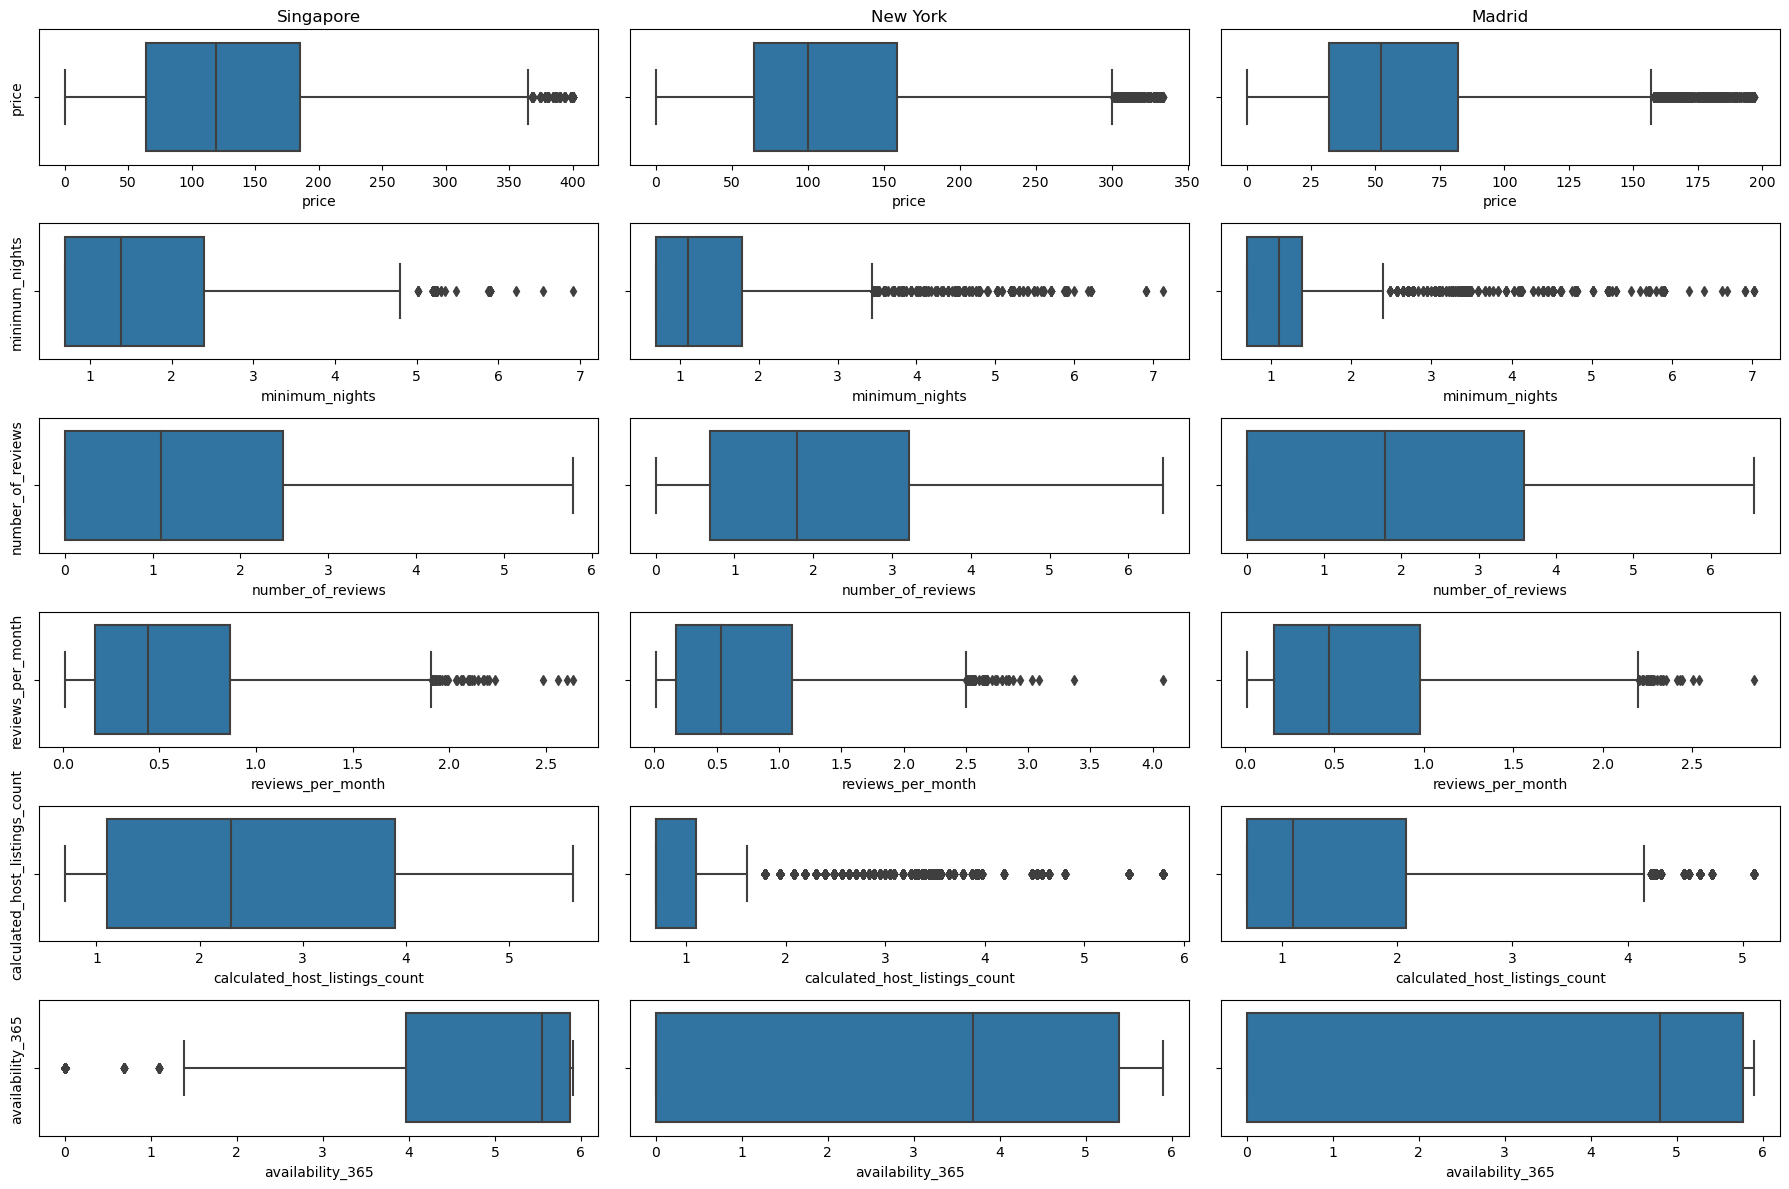

In [115]:
outlier_visual([singapore_df_log, ny_df_log, madrid_df_log])

#### Results

In [103]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_log, get_prediction(singapore_X_train_log, singapore_y_train_log, singapore_X_test_log, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_log, get_prediction(singapore_X_train_log, singapore_y_train_log, singapore_X_test_log, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_log, get_prediction(singapore_X_train_log, singapore_y_train_log, singapore_X_test_log, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_log, get_prediction(ny_X_train_log, ny_y_train_log, ny_X_test_log, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_log, get_prediction(ny_X_train_log, ny_y_train_log, ny_X_test_log, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_log, get_prediction(ny_X_train_log, ny_y_train_log, ny_X_test_log, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_log, get_prediction(madrid_X_train_log, madrid_y_train_log, madrid_X_test_log, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_log, get_prediction(madrid_X_train_log, madrid_y_train_log, madrid_X_test_log, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_log, get_prediction(madrid_X_train_log, madrid_y_train_log, madrid_X_test_log, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore:
Random Forest Regressor: RSME: 48.36469182604776, MAE: 33.30085714285715, R2: 0.6770135873057745
Linear Regression: RSME: 61.507767116374644, MAE: 46.683411863430564, R2: 0.4776190559227613
XGBoost: RSME: 49.71600348954791, MAE: 34.76775409572727, R2: 0.6587129394422511

NY:
Random Forest Regressor: RSME: 44.80150174033424, MAE: 31.928174009823135, R2: 0.5665853446990612
Linear Regression: RSME: 46.67950357397799, MAE: 34.14904110763615, R2: 0.5294877809891483
XGBoost: RSME: 44.42838322192682, MAE: 31.846479951534977, R2: 0.573774462270006

Madrid:
Random Forest Regressor: RSME: 28.564055230972794, MAE: 20.135489327383194, R2: 0.4783270159527143
Linear Regression: RSME: 31.715975526954185, MAE: 23.111569509517125, R2: 0.3568463091334172
XGBoost: RSME: 28.885838483351815, MAE: 20.552626337762117, R2: 0.46650718447403716


### Outlier Removal

In [104]:
numeric_features = [
            'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price'
        ]
# 3. Outlier Removal
def remove_outliers(df):
    transformed_df = df.copy()
    for feature in numeric_features:
        Q1 = transformed_df[feature].quantile(0.25)
        Q3 = transformed_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        transformed_df = transformed_df[(transformed_df[feature] >= lower_bound) & (transformed_df[feature] <= upper_bound)]
    return transformed_df

singapore_df_no_outliers = remove_outliers(singapore_df)
ny_df_no_outliers = remove_outliers(ny_df)
madrid_df_no_outliers = remove_outliers(madrid_df)

singapore_X_no_outliers, singapore_y_no_outliers = get_X_y(singapore_df_no_outliers)
ny_X_no_outliers, ny_y_no_outliers = get_X_y(ny_df_no_outliers)
madrid_X_no_outliers, madrid_y_no_outliers = get_X_y(madrid_df_no_outliers)


# Split the data into training and testing sets
singapore_X_train_no_outliers, singapore_X_test_no_outliers, singapore_y_train_no_outliers, singapore_y_test_no_outliers = train_test_split(singapore_X_no_outliers, singapore_y_no_outliers, test_size=0.3, random_state=42)
ny_X_train_no_outliers, ny_X_test_no_outliers, ny_y_train_no_outliers, ny_y_test_no_outliers = train_test_split(ny_X_no_outliers, ny_y_no_outliers, test_size=0.3, random_state=42)
madrid_X_train_no_outliers, madrid_X_test_no_outliers, madrid_y_train_no_outliers, madrid_y_test_no_outliers = train_test_split(madrid_X_no_outliers, madrid_y_no_outliers, test_size=0.3, random_state=42)

#### Outlier Visual After Removal

Singapore
Before: 7907, After: 2646

NY
Before: 48895, After: 22366

Madrid
Before: 19618, After: 7828


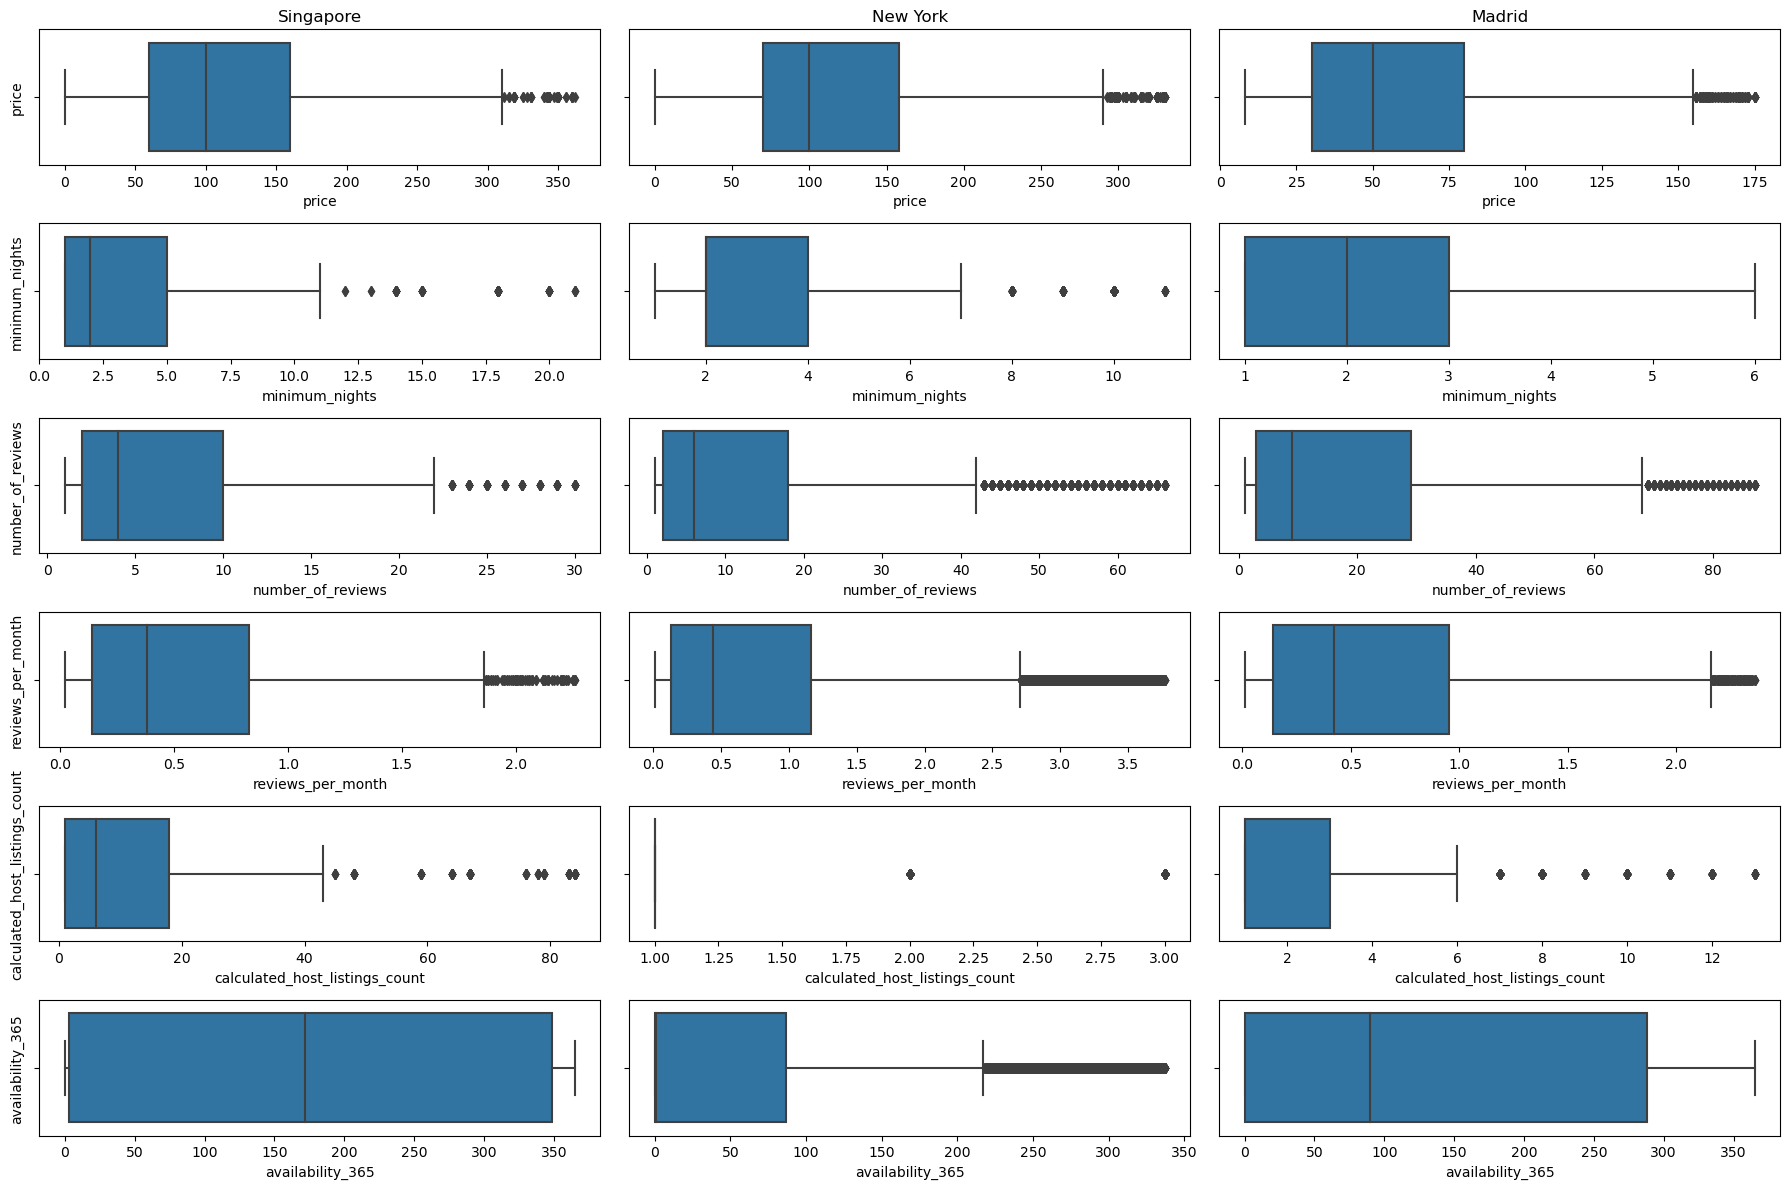

In [116]:
print("Singapore")
print(f"Before: {singapore_df.shape[0]}, After: {singapore_df_no_outliers.shape[0]}")
print("\nNY")
print(f"Before: {ny_df.shape[0]}, After: {ny_df_no_outliers.shape[0]}")
print("\nMadrid")
print(f"Before: {madrid_df.shape[0]}, After: {madrid_df_no_outliers.shape[0]}")

outlier_visual([singapore_df_no_outliers, ny_df_no_outliers, madrid_df_no_outliers])

#### Results

In [106]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_no_outliers, get_prediction(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_no_outliers, get_prediction(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_no_outliers, get_prediction(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, xg_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_no_outliers, get_prediction(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_no_outliers, get_prediction(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_no_outliers, get_prediction(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, xg_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_no_outliers, get_prediction(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, rf_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_no_outliers, get_prediction(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, lr_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_no_outliers, get_prediction(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, xg_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")


Singapore:
Random Forest Regressor: RSME: 48.51617599963134, MAE: 32.11346347607053, R2: 0.6234805477500247
Linear Regression: RSME: 56.07902203386066, MAE: 40.919561043468065, R2: 0.49694536458519556
XGBoost: RSME: 50.17603380076968, MAE: 33.703388272364734, R2: 0.5972765200567586

NY:
Random Forest Regressor: RSME: 44.868216393897335, MAE: 32.69717585692995, R2: 0.5349549638881479
Linear Regression: RSME: 45.245395720741065, MAE: 33.31223742973598, R2: 0.5271034088213511
XGBoost: RSME: 45.027192112107265, MAE: 32.787649348809005, R2: 0.53165365844808

Madrid:
Random Forest Regressor: RSME: 25.866972915758932, MAE: 18.626534695615153, R2: 0.4918895770705416
Linear Regression: RSME: 27.13103725296139, MAE: 19.837245687141092, R2: 0.4410156070150104
XGBoost: RSME: 26.640707282791837, MAE: 19.187883049439957, R2: 0.461037699029771


### HyperParameter Tuning using Randomized Search CV

In [107]:
# Define hyperparameters for each model
rf_params = {
    'model__n_estimators': [int(x) for x in np.linspace(100, 1000, num=20)],
    'model__max_features': ['log2', 'sqrt'],
    'model__max_depth': [int(x) for x in np.linspace(10, 150, num=11)],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 10],
    'model__bootstrap': [True, False],
}

lr_params = {
    'model__fit_intercept': [True, False],
}

xgb_params = {
    'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [3, 4, 5, 6],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'model__reg_alpha': [0, 0.1, 0.2, 0.3, 0.5],
    'model__reg_lambda': [0, 0.1, 0.2, 0.3, 0.5],
    'model__gamma': [0, 1, 2],
}

# Perform hyperparameter search with the subsets
def get_hyperparameter_search(model, params):
    rnd_search_cv = RandomizedSearchCV(
        model, params, cv=3, n_iter=10, random_state=42, n_jobs=1, scoring='neg_mean_squared_error'
    )
    # rnd_search_cv.fit(X_train, y_train)
    return rnd_search_cv

rf_search_model = get_hyperparameter_search(rf_model, rf_params)
lr_search_model = get_hyperparameter_search(lr_model, lr_params)
xgb_search_model = get_hyperparameter_search(xg_model, xgb_params)

def get_prediction_cv(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)    
    best_model = model.best_estimator_
    y_pred = best_model.predict(X_test)
    return y_pred


##### Improved Preprocessing V2 (Price Outlier Removal)

In [108]:
singapore_X_improvedv2, singapore_y_improvedv2 = get_X_y(singapore_drop_target_outliers)
ny_X_improvedv2, ny_y_improvedv2 = get_X_y(ny_drop_target_outliers)
madrid_X_improvedv2, madrid_y_improvedv2 = get_X_y(madrid_drop_target_outliers)

# Split the data into training and testing sets
singapore_X_train_impv2, singapore_X_test_impv2, singapore_y_train_impv2, singapore_y_test_impv2 = train_test_split(singapore_X_improvedv2, singapore_y_improvedv2, test_size=0.3, random_state=42)
ny_X_train_impv2, ny_X_test_impv2, ny_y_train_impv2, ny_y_test_impv2 = train_test_split(ny_X_improvedv2, ny_y_improvedv2, test_size=0.3, random_state=42)
madrid_X_train_impv2, madrid_X_test_impv2, madrid_y_train_impv2, madrid_y_test_impv2 = train_test_split(madrid_X_improvedv2, madrid_y_improvedv2, test_size=0.3, random_state=42)

In [109]:
# Calculate metrics for each city
# Singapore
singapore_rf_rmse, singapore_rf_mae, singapore_rf_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction_cv(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, rf_search_model))
singapore_lr_rmse, singapore_lr_mae, singapore_lr_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction_cv(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, lr_search_model))
singapore_xgb_rmse, singapore_xgb_mae, singapore_xgb_r2 = calculate_metrics(singapore_y_test_impv2, get_prediction_cv(singapore_X_train_impv2, singapore_y_train_impv2, singapore_X_test_impv2, xgb_search_model))

print("Singapore")
print(f'Random Forest Regressor RMSE: {singapore_rf_rmse}, MAE: {singapore_rf_mae}', f'R2: {singapore_rf_r2}')
print(f'Linear Regression RMSE: {singapore_lr_rmse}, MAE: {singapore_lr_mae}', f'R2: {singapore_lr_r2}')
print(f'XGBoost RMSE: {singapore_xgb_rmse}, MAE: {singapore_xgb_mae}', f'R2: {singapore_xgb_r2}')


# New York
ny_rf_rmse, ny_rf_mae, ny_rf_r2 = calculate_metrics(ny_y_test_impv2, get_prediction_cv(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, rf_search_model))
ny_lr_rmse, ny_lr_mae, ny_lr_r2 = calculate_metrics(ny_y_test_impv2, get_prediction_cv(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, lr_search_model))
ny_xgb_rmse, ny_xgb_mae, ny_xgb_r2 = calculate_metrics(ny_y_test_impv2, get_prediction_cv(ny_X_train_impv2, ny_y_train_impv2, ny_X_test_impv2, xgb_search_model))

print("\nNew York")
print(f'Random Forest Regressor RMSE: {ny_rf_rmse}, MAE: {ny_rf_mae}', f'R2: {ny_rf_r2}')
print(f'Linear Regression RMSE: {ny_lr_rmse}, MAE: {ny_lr_mae}', f'R2: {ny_lr_r2}')
print(f'XGBoost RMSE: {ny_xgb_rmse}, MAE: {ny_xgb_mae}', f'R2: {ny_xgb_r2}')


# Madrid
madrid_rf_rmse, madrid_rf_mae, madrid_rf_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction_cv(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, rf_search_model))
madrid_lr_rmse, madrid_lr_mae, madrid_lr_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction_cv(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, lr_search_model))
madrid_xgb_rmse, madrid_xgb_mae, madrid_xgb_r2 = calculate_metrics(madrid_y_test_impv2, get_prediction_cv(madrid_X_train_impv2, madrid_y_train_impv2, madrid_X_test_impv2, xgb_search_model))

print("\nMadrid")
print(f'Random Forest Regressor RMSE: {madrid_rf_rmse}, MAE: {madrid_rf_mae}', f'R2: {madrid_rf_r2}')
print(f'Linear Regression RMSE: {madrid_lr_rmse}, MAE: {madrid_lr_mae}', f'R2: {madrid_lr_r2}')
print(f'XGBoost RMSE: {madrid_xgb_rmse}, MAE: {madrid_xgb_mae}', f'R2: {madrid_xgb_r2}')

Singapore
Random Forest Regressor RMSE: 47.82003598938959, MAE: 33.38043064860282 R2: 0.6842472072246222
Linear Regression RMSE: 62.208115566761634, MAE: 47.51711841733408 R2: 0.46565531407345173
XGBoost RMSE: 49.23383282629874, MAE: 34.56883311806144 R2: 0.6653007828333536

New York
Random Forest Regressor RMSE: 44.16909670793448, MAE: 31.637656180774275 R2: 0.5787348970812791
Linear Regression RMSE: 47.31484857673847, MAE: 34.5407757502943 R2: 0.5165925292119593
XGBoost RMSE: 44.15147551624683, MAE: 31.66230389825611 R2: 0.579070956133757

Madrid
Random Forest Regressor RMSE: 28.47508656773759, MAE: 20.263234369538 R2: 0.4815716720015415
Linear Regression RMSE: 31.832613452305075, MAE: 23.172640026134793 R2: 0.3521071169956801
XGBoost RMSE: 28.6847250193671, MAE: 20.643587705669074 R2: 0.4739100565530703


### Outlier Removal for both price and numberic features

In [117]:
singapore_df_no_outliers = remove_outliers(singapore_df)
ny_df_no_outliers = remove_outliers(ny_df)
madrid_df_no_outliers = remove_outliers(madrid_df)

singapore_X_no_outliers, singapore_y_no_outliers = get_X_y(singapore_df_no_outliers)
ny_X_no_outliers, ny_y_no_outliers = get_X_y(ny_df_no_outliers)
madrid_X_no_outliers, madrid_y_no_outliers = get_X_y(madrid_df_no_outliers)


# Split the data into training and testing sets
singapore_X_train_no_outliers, singapore_X_test_no_outliers, singapore_y_train_no_outliers, singapore_y_test_no_outliers = train_test_split(singapore_X_no_outliers, singapore_y_no_outliers, test_size=0.3, random_state=42)
ny_X_train_no_outliers, ny_X_test_no_outliers, ny_y_train_no_outliers, ny_y_test_no_outliers = train_test_split(ny_X_no_outliers, ny_y_no_outliers, test_size=0.3, random_state=42)
madrid_X_train_no_outliers, madrid_X_test_no_outliers, madrid_y_train_no_outliers, madrid_y_test_no_outliers = train_test_split(madrid_X_no_outliers, madrid_y_no_outliers, test_size=0.3, random_state=42)

In [118]:
rmse_rf, mae_rf, r2_rf = calculate_metrics(singapore_y_test_no_outliers, get_prediction_cv(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, rf_search_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(singapore_y_test_no_outliers, get_prediction_cv(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, lr_search_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(singapore_y_test_no_outliers, get_prediction_cv(singapore_X_train_no_outliers, singapore_y_train_no_outliers, singapore_X_test_no_outliers, xgb_search_model))

print("Singapore:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(ny_y_test_no_outliers, get_prediction_cv(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, rf_search_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(ny_y_test_no_outliers, get_prediction_cv(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, lr_search_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(ny_y_test_no_outliers, get_prediction_cv(ny_X_train_no_outliers, ny_y_train_no_outliers, ny_X_test_no_outliers, xgb_search_model))

print("\nNY:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

rmse_rf, mae_rf, r2_rf = calculate_metrics(madrid_y_test_no_outliers, get_prediction_cv(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, rf_search_model))
rmse_lr, mae_lr, r2_lr = calculate_metrics(madrid_y_test_no_outliers, get_prediction_cv(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, lr_search_model))
rmse_xg, mae_xg, r2_xg = calculate_metrics(madrid_y_test_no_outliers, get_prediction_cv(madrid_X_train_no_outliers, madrid_y_train_no_outliers, madrid_X_test_no_outliers, xgb_search_model))

print("\nMadrid:")
print(f"Random Forest Regressor: RSME: {rmse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Linear Regression: RSME: {rmse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"XGBoost: RSME: {rmse_xg}, MAE: {mae_xg}, R2: {r2_xg}")

Singapore:
Random Forest Regressor: RSME: 47.156849879575496, MAE: 32.39097371345572, R2: 0.6442836193770386
Linear Regression: RSME: 56.087250788593124, MAE: 40.92197001706812, R2: 0.49679772232014074
XGBoost: RSME: 50.3096174844699, MAE: 34.67561693455771, R2: 0.5951293237099932

NY:
Random Forest Regressor: RSME: 44.36230339220668, MAE: 32.398798687185426, R2: 0.5453830993756101
Linear Regression: RSME: 45.245395720741065, MAE: 33.31223742973598, R2: 0.5271034088213511
XGBoost: RSME: 43.939550346910686, MAE: 31.962175863581514, R2: 0.5540064087466685

Madrid:
Random Forest Regressor: RSME: 25.695263355718748, MAE: 18.702866318610813, R2: 0.49861304143039
Linear Regression: RSME: 27.13103725296139, MAE: 19.837245687141092, R2: 0.4410156070150104
XGBoost: RSME: 25.96379798571271, MAE: 18.86636518650534, R2: 0.48807854700650655
